# Setup Imports


Code from: https://arena-ch1-transformers.streamlit.app/[1.3]_Indirect_Object_Identification

In [1]:
try:
    import google.colab # type: ignore
    IN_COLAB = True
except:
    IN_COLAB = False

import os, sys

if IN_COLAB:
    # Install packages
    %pip install einops
    %pip install jaxtyping
    %pip install transformer_lens
    # %pip install git+https://github.com/callummcdougall/CircuitsVis.git#subdirectory=python

    # Code to download the necessary files (e.g. solutions, test funcs)
    import os, sys
    if not os.path.exists("chapter1_transformers"):
        !curl -o /content/main.zip https://codeload.github.com/callummcdougall/ARENA_2.0/zip/refs/heads/main
        !unzip /content/main.zip 'ARENA_2.0-main/chapter1_transformers/exercises/*'
        sys.path.append("/content/ARENA_2.0-main/chapter1_transformers/exercises")
        os.remove("/content/main.zip")
        os.rename("ARENA_2.0-main/chapter1_transformers", "chapter1_transformers")
        os.rmdir("ARENA_2.0-main")
        os.chdir("chapter1_transformers/exercises")
else:
    from IPython import get_ipython
    ipython = get_ipython()
    ipython.run_line_magic("load_ext", "autoreload")
    ipython.run_line_magic("autoreload", "2")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 969.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.0/119.0 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.7/739.7 kB 48.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 42.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 80.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 75.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 58.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 59.6 MB/s eta 0:00:00
     ━━━━━━━━━━

In [2]:
import os; os.environ["ACCELERATE_DISABLE_RICH"] = "1"
import sys
from pathlib import Path
import torch as t
from torch import Tensor
import numpy as np
import einops
from tqdm.notebook import tqdm
import plotly.express as px
import webbrowser
import re
import itertools
from jaxtyping import Float, Int, Bool
from typing import List, Optional, Callable, Tuple, Dict, Literal, Set
from functools import partial
from IPython.display import display, HTML
from rich.table import Table, Column
from rich import print as rprint
# import circuitsvis as cv
from pathlib import Path
from transformer_lens.hook_points import HookPoint
from transformer_lens import utils, HookedTransformer, ActivationCache
from transformer_lens.components import Embed, Unembed, LayerNorm, MLP

t.set_grad_enabled(False)

# Make sure exercises are in the path
chapter = r"chapter1_transformers"
exercises_dir = Path(f"{os.getcwd().split(chapter)[0]}/{chapter}/exercises").resolve()
section_dir = (exercises_dir / "part3_indirect_object_identification").resolve()
if str(exercises_dir) not in sys.path: sys.path.append(str(exercises_dir))

# from plotly_utils import imshow, line, scatter, bar
# import part3_indirect_object_identification.tests as tests

device = t.device("cuda") if t.cuda.is_available() else t.device("cpu")

MAIN = __name__ == "__main__"

/usr/local/lib/python3.10/dist-packages/accelerate/utils/imports.py:193: UserWarning: `ACCELERATE_DISABLE_RICH` is deprecated and will be removed in v0.22.0 and deactivated by default. Please use `ACCELERATE_ENABLE_RICH` if you wish to use `rich`.
  warnings.warn(


In [3]:
from part3_indirect_object_identification.ioi_dataset import NAMES, IOIDataset

## Load Model

In [4]:
model = HookedTransformer.from_pretrained(
    "gpt2-small",
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    refactor_factored_attn_matrices=True,
)

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Loaded pretrained model gpt2-small into HookedTransformer


# Generate dataset with multiple prompts

In [5]:
import torch

In [6]:
class Dataset:
    def __init__(self, prompts, pos_dict, tokenizer, S1_is_first=False):
        self.prompts = prompts
        self.tokenizer = tokenizer
        self.N = len(prompts)
        self.max_len = max(
            [
                len(self.tokenizer(prompt["text"]).input_ids)
                for prompt in self.prompts
            ]
        )
        # all_ids = [prompt["TEMPLATE_IDX"] for prompt in self.ioi_prompts]
        all_ids = [0 for prompt in self.prompts] # only 1 template
        all_ids_ar = np.array(all_ids)
        self.groups = []
        for id in list(set(all_ids)):
            self.groups.append(np.where(all_ids_ar == id)[0])

        texts = [ prompt["text"] for prompt in self.prompts ]
        self.toks = torch.Tensor(self.tokenizer(texts, padding=True).input_ids).type(
            torch.int
        )
        self.corr_tokenIDs = [
            # self.tokenizer.encode(" " + prompt["corr"])[0] for prompt in self.prompts
            self.tokenizer.encode(prompt["corr"])[0] for prompt in self.prompts
        ]
        self.incorr_tokenIDs = [
            # self.tokenizer.encode(" " + prompt["incorr"])[0] for prompt in self.prompts
            self.tokenizer.encode(prompt["incorr"])[0] for prompt in self.prompts
        ]

        # word_idx: for every prompt, find the token index of each target token and "end"
        # word_idx is a tensor with an element for each prompt. The element is the targ token's ind at that prompt
        self.word_idx = {}
        # for targ in [key for key in self.prompts[0].keys() if (key != 'text' and key != 'corr' and key != 'incorr')]:
        for targ in [key for key in pos_dict]:
            targ_lst = []
            for prompt in self.prompts:
                input_text = prompt["text"]
                tokens = model.tokenizer.tokenize(input_text)
                # if S1_is_first and targ == "S1":  # only use this if first token doesn't have space Ġ in front
                #     target_token = prompt[targ]
                # else:
                #     target_token = "Ġ" + prompt[targ]
                # target_index = tokens.index(target_token)
                target_index = pos_dict[targ]
                targ_lst.append(target_index)
            self.word_idx[targ] = torch.tensor(targ_lst)

        targ_lst = []
        for prompt in self.prompts:
            input_text = prompt["text"]
            tokens = self.tokenizer.tokenize(input_text)
            end_token_index = len(tokens) - 1
            targ_lst.append(end_token_index)
        self.word_idx["end"] = torch.tensor(targ_lst)

    def __len__(self):
        return self.N

In [7]:
import pickle

prompts_list = []

temps = ['done', 'lost', 'names']

for i in temps:
    file_name = f'/content/digits_prompts_{i}.pkl'
    with open(file_name, 'rb') as file:
        filelist = pickle.load(file)

    print(filelist[0]['text'])
    prompts_list += filelist [:512] #768 512

len(prompts_list)

Van done in 1. Hat done in 2. Ring done in 3. Desk done in 4. Sun done in
Oil lost in 1. Apple lost in 2. Tree lost in 3. Snow lost in 4. Apple lost in
Marcus born in 1. Victoria born in 2. George born in 3. Brandon born in 4. Jamie born in


1536

In [8]:
# pos_dict = {
#     'S1': 4,
#     'S2': 10,
#     'S3': 16,
#     'S4': 22,
# }

pos_dict = {}
for i in range(len(model.tokenizer.tokenize(prompts_list[0]['text']))):
    pos_dict['S'+str(i)] = i

# pos_dict

In [9]:
# import random

# def generate_prompts_list_corr(prompt_list):
#     outlist = []
#     for prompt_dict in prompts_list:
#         r1 = random.randint(1, 12)
#         r2 = random.randint(1, 12)
#         while True:
#             r3 = random.randint(1, 12)
#             r4 = random.randint(1, 12)
#             if r4 - 1 != r3:
#                 break
#         new_text = prompt_dict['text'].replace(prompt_dict['S1'], str(r1)).replace(prompt_dict['S2'], str(r2)).replace(prompt_dict['S3'], str(r3)).replace(prompt_dict['S4'], str(r4))
#         new_prompt_dict = {
#             'S1': str(r1),
#             'S2': str(r2),
#             'S3': str(r3),
#             'S4': str(r4),
#             'corr': prompt_dict['corr'],
#             'incorr': prompt_dict['incorr'],
#             'text': new_text
#         }
#         outlist.append(new_prompt_dict)
#     return outlist
# prompts_list_2 = generate_prompts_list_corr(prompts_list)

In [10]:
import pickle
file_name = '/content/randDS_numerals.pkl'
with open(file_name, 'rb') as file:
    prompts_list_2 = pickle.load(file)

In [11]:
prompts_list = prompts_list[:500]
prompts_list_2 = prompts_list_2[:500]

In [12]:
dataset = Dataset(prompts_list, pos_dict, model.tokenizer, S1_is_first=True)

In [13]:
dataset_1 = dataset

In [14]:
dataset_2 = Dataset(prompts_list_2, pos_dict, model.tokenizer, S1_is_first=True)

# Path patching fns

## Performance Metrics

In [15]:
import gc

# del(ioi_cache)
# del(ioi_logits_original)

torch.cuda.empty_cache()
gc.collect()

18

In [16]:
def logits_to_ave_logit_diff_2(logits: Float[Tensor, "batch seq d_vocab"], dataset_1: IOIDataset = dataset_1, per_prompt=False):
    '''
    Returns logit difference between the correct and incorrect answer.

    If per_prompt=True, return the array of differences rather than the average.
    '''

    # Only the final logits are relevant for the answer
    # Get the logits corresponding to the indirect object / subject tokens respectively
    corr_logits: Float[Tensor, "batch"] = logits[range(logits.size(0)), dataset_1.word_idx["end"], dataset_1.corr_tokenIDs]
    incorr_logits: Float[Tensor, "batch"] = logits[range(logits.size(0)), dataset_1.word_idx["end"], dataset_1.incorr_tokenIDs]
    # Find logit difference
    answer_logit_diff = corr_logits - incorr_logits
    return answer_logit_diff if per_prompt else answer_logit_diff.mean()

model.reset_hooks(including_permanent=True)

ioi_logits_original = model(dataset_1.toks)
abc_logits_original = model(dataset_2.toks)

ioi_average_logit_diff = logits_to_ave_logit_diff_2(ioi_logits_original).item()
abc_average_logit_diff = logits_to_ave_logit_diff_2(abc_logits_original).item()
orig_score = ioi_average_logit_diff

In [17]:
def ioi_metric_2(
    logits: Float[Tensor, "batch seq d_vocab"],
    clean_logit_diff: float = ioi_average_logit_diff,
    corrupted_logit_diff: float = abc_average_logit_diff,
    dataset_1: IOIDataset = dataset_1,
) -> float:
    '''
    We calibrate this so that the value is 0 when performance isn't harmed (i.e. same as IOI dataset),
    and -1 when performance has been destroyed (i.e. is same as ABC dataset).
    '''
    patched_logit_diff = logits_to_ave_logit_diff_2(logits, dataset_1)
    return (patched_logit_diff - clean_logit_diff) / (clean_logit_diff - corrupted_logit_diff)


print(f"IOI metric (IOI dataset): {ioi_metric_2(ioi_logits_original):.4f}")
print(f"IOI metric (ABC dataset): {ioi_metric_2(abc_logits_original):.4f}")

IOI metric (IOI dataset): 0.0000
IOI metric (ABC dataset): -1.0000


0 means performance is the same as on the IOI dataset (i.e. hasn't been harmed in any way), and -1 means performance is the same as on the ABC dataset (i.e. the model has completely lost the ability to distinguish between the subject and indirect object).


clean - corrupt normalized to between 0 and 1 because it is the LARGEST possible DIFFERENCE. patched-clean is a RESTORED DIFFERENCE. thus, total restoration is 0, while no restoration is -1 as it is the same as corrupt-clean (but since we switch the subtraction terms, it’s -1 instead of 1)

The `patched_logit_diff` should be LOWER because it takes an edge (sender to header) from the corrupted! So if it’s higher, that edge is really bad and not necessary. Thus, DO NOT take abslute values, only take most negative.

To be more in line with iterative node thres, we can use a diff metric: `patched_logit_diff` / `clean_logit_diff`

In [18]:
def ioi_metric_3(
    logits: Float[Tensor, "batch seq d_vocab"],
    clean_logit_diff: float = ioi_average_logit_diff,
    corrupted_logit_diff: float = abc_average_logit_diff,
    dataset_1: IOIDataset = dataset_1,
) -> float:
    patched_logit_diff = logits_to_ave_logit_diff_2(logits, dataset_1)
    return (patched_logit_diff / clean_logit_diff)

print(f"IOI metric (IOI dataset): {ioi_metric_3(ioi_logits_original):.4f}")
print(f"IOI metric (ABC dataset): {ioi_metric_3(abc_logits_original):.4f}")

IOI metric (IOI dataset): 1.0000
IOI metric (ABC dataset): -0.0038


Those that go below % threshold are kept

In [19]:
del(ioi_logits_original)
del(abc_logits_original)

## head to head

In [21]:
def patch_or_freeze_head_vectors(
    orig_head_vector: Float[Tensor, "batch pos head_index d_head"],
    hook: HookPoint,
    new_cache: ActivationCache,
    orig_cache: ActivationCache,
    head_to_patch: Tuple[int, int],
) -> Float[Tensor, "batch pos head_index d_head"]:
    '''
    This helps implement step 2 of path patching. We freeze all head outputs (i.e. set them
    to their values in orig_cache), except for head_to_patch (if it's in this layer) which
    we patch with the value from new_cache.

    head_to_patch: tuple of (layer, head)
        we can use hook.layer() to check if the head to patch is in this layer
    '''
    # Setting using ..., otherwise changing orig_head_vector will edit cache value too
    orig_head_vector[...] = orig_cache[hook.name][...]
    if head_to_patch[0] == hook.layer():
        orig_head_vector[:, :, head_to_patch[1]] = new_cache[hook.name][:, :, head_to_patch[1]]
    return orig_head_vector

In [22]:
def patch_head_input(
    orig_activation: Float[Tensor, "batch pos head_idx d_head"],
    hook: HookPoint,
    patched_cache: ActivationCache,
    head_list: List[Tuple[int, int]],
) -> Float[Tensor, "batch pos head_idx d_head"]:
    '''
    Function which can patch any combination of heads in layers,
    according to the heads in head_list.
    '''
    heads_to_patch = [head for layer, head in head_list if layer == hook.layer()]
    orig_activation[:, :, heads_to_patch] = patched_cache[hook.name][:, :, heads_to_patch]
    return orig_activation



def get_path_patch_head_to_heads(
    receiver_heads: List[Tuple[int, int]],
    receiver_input: str,
    model: HookedTransformer,
    patching_metric: Callable,
    new_dataset: IOIDataset = dataset_2,
    orig_dataset: IOIDataset = dataset_1,
    new_cache: Optional[ActivationCache] = None,
    orig_cache: Optional[ActivationCache] = None,
) -> Float[Tensor, "layer head"]:
    '''
    Performs path patching (see algorithm in appendix B of IOI paper), with:

        sender head = (each head, looped through, one at a time)
        receiver node = input to a later head (or set of heads)

    The receiver node is specified by receiver_heads and receiver_input.
    Example (for S-inhibition path patching the queries):
        receiver_heads = [(8, 6), (8, 10), (7, 9), (7, 3)],
        receiver_input = "v"

    Returns:
        tensor of metric values for every possible sender head
    '''
    # SOLUTION
    model.reset_hooks()

    assert receiver_input in ("k", "q", "v")
    receiver_layers = set(next(zip(*receiver_heads)))
    receiver_hook_names = [utils.get_act_name(receiver_input, layer) for layer in receiver_layers]
    receiver_hook_names_filter = lambda name: name in receiver_hook_names

    results = t.zeros(max(receiver_layers), model.cfg.n_heads, device="cuda", dtype=t.float32)

    # ========== Step 1 ==========
    # Gather activations on x_orig and x_new

    # Note the use of names_filter for the run_with_cache function. Using it means we
    # only cache the things we need (in this case, just attn head outputs).
    z_name_filter = lambda name: name.endswith("z")
    if new_cache is None:
        _, new_cache = model.run_with_cache(
            new_dataset.toks,
            names_filter=z_name_filter,
            return_type=None
        )
    if orig_cache is None:
        _, orig_cache = model.run_with_cache(
            orig_dataset.toks,
            names_filter=z_name_filter,
            return_type=None
        )

    # Note, the sender layer will always be before the final receiver layer, otherwise there will
    # be no causal effect from sender -> receiver. So we only need to loop this far.
    for (sender_layer, sender_head) in tqdm(list(itertools.product(
        range(max(receiver_layers)),
        range(model.cfg.n_heads)
    ))):

        # ========== Step 2 ==========
        # Run on x_orig, with sender head patched from x_new, every other head frozen

        hook_fn = partial(
            patch_or_freeze_head_vectors,
            new_cache=new_cache,
            orig_cache=orig_cache,
            head_to_patch=(sender_layer, sender_head),
        )
        model.add_hook(z_name_filter, hook_fn, level=1)

        _, patched_cache = model.run_with_cache(
            orig_dataset.toks,
            names_filter=receiver_hook_names_filter,
            return_type=None
        )
        # model.reset_hooks(including_permanent=True)
        assert set(patched_cache.keys()) == set(receiver_hook_names)

        # ========== Step 3 ==========
        # Run on x_orig, patching in the receiver node(s) from the previously cached value

        hook_fn = partial(
            patch_head_input,
            patched_cache=patched_cache,
            head_list=receiver_heads,
        )
        patched_logits = model.run_with_hooks(
            orig_dataset.toks,
            fwd_hooks = [(receiver_hook_names_filter, hook_fn)],
            return_type="logits"
        )

        # Save the results
        results[sender_layer, sender_head] = patching_metric(patched_logits)

    return results

## mlp to mlp

In [23]:
# def patch_or_freeze_head_vectors(
def patch_or_freeze_mlp_vectors(
    # orig_head_vector: Float[Tensor, "batch pos head_index d_head"],
    orig_MLP_vector: Float[Tensor, "batch pos d_model"],
    hook: HookPoint,
    new_cache: ActivationCache,
    orig_cache: ActivationCache,
    # head_to_patch: Tuple[int, int],
    layer_to_patch: int,
# ) -> Float[Tensor, "batch pos head_index d_head"]:
) -> Float[Tensor, "batch pos d_model"]:
    '''
    This helps implement step 2 of path patching. We freeze all head outputs (i.e. set them
    to their values in orig_cache), except for head_to_patch (if it's in this layer) which
    we patch with the value from new_cache.

    head_to_patch: tuple of (layer, head)
        we can use hook.layer() to check if the head to patch is in this layer
    '''
    # the layer is hook.layer(), and orig_head_vector is ALREADY an MLP at a layer, so we don't get it by layer
    # we just have to patch in each neuron of the MLP (d_model) that's why dims are "batch pos d_model"

    # Setting using ..., otherwise changing orig_head_vector will edit cache value too
    # this keeps everything the same
    # we NEED this to prevent change by ref!
    # orig_head_vector[...] = orig_cache[hook.name][...]
    # orig_MLP_vector[...] = orig_cache[hook.name][...]

    # this change the one MLP layer
    # if head_to_patch[0] == hook.layer():
    #     orig_head_vector[:, :, head_to_patch[1]] = new_cache[hook.name][:, :, head_to_patch[1]]

    # set the entire sender head as new (corr) cache output actvs
    if layer_to_patch == hook.layer():
        orig_MLP_vector[:, :, :] = new_cache[hook.name][:, :, :]
    return orig_MLP_vector

In [37]:
def patch_mlp_input(
# def patch_head_input(
    # orig_activation: Float[Tensor, "batch pos head_idx d_head"],
    orig_activation: Float[Tensor, "batch pos d_model"],
    hook: HookPoint,
    patched_cache: ActivationCache,
    # head_list: List[Tuple[int, int]],
    layer_list: List[int],
) -> Float[Tensor, "batch pos head_idx d_head"]:
    '''
    Function which can patch any combination of heads in layers,
    according to the heads in head_list.
    '''
    # heads_to_patch = [head for layer, head in head_list if layer == hook.layer()]  # we dont need list, just layer int
    # orig_activation[:, :, heads_to_patch] = patched_cache[hook.name][:, :, heads_to_patch] # heads_to_patch should now be an int, layer?

    # exact same thing as before, since we don't need to freeze other heads, so uinlike
    # w/ attn heads, this is the same fn. we can just re-use the prev one instead of this one
    # we also don't have a head list, but an MLP list
    # ACCTU this is diff; there's al ist of layer ints, and only if layer in list do we patch

    # orig_activation[...] = orig_cache[hook.name][...]  # we dont need this? but by ref? postpone thinking this

    if hook.layer() in layer_list:
        # pdb.set_trace()
        orig_activation[:, :, :] = patched_cache[hook.name][:, :, :]
    return orig_activation

"""
receiver_heads are from the circuit. we loop thru all sender thats that go into them
these senders can be both MLP or head

get_path_patch_head_to_heads() is for a list of receiver heads, from all sender heads.
the sender heads are used in step 2, with patch_or_freeze_head_vectors().
the receiver heads are used in step 3, with patch_head_input().

step 2 obtains a cache for receiver head activations which are patched in at step 3.
run with hooks takes a list of actvs and patches them all in.

step 3 is head or MLP specific. thus, we need four fns:
get_path_patch_MLPs_to_MLPs
get_path_patch_MLPs_to_heads
get_path_patch_heads_to_MLPs
get_path_patch_heads_to_heads

we can also combine the senders into one:
get_path_patch_MLPs
etc

but results works on [layer, head], and is a 2D tensor. we can have another results
that's just a 1D tensor for MLPs.

results_dict[receiver_head] = logit_diff for every component = result
head_adjList[head] = edges_within_threshold(result, Ethres)
we can also do edges_within_threshold on a 1D tensor for MLPs.
then head_from_MLP_adjList is head:MLP for MLP -> heads

step 2:
Thus, we need both patch_or_freeze_head_vectors() and patch_or_freeze_MLP_vectors()
because both heads and MLPs can be sender heads (not from circ, but looping thru all)

however, with our circuit, we can loop thru all the heads in circuit, NOT
model.cfg.n_heads.

"""

def get_path_patch_MLPs_to_MLPs(
# def get_path_patch_head_to_heads(
    # receiver_heads: List[Tuple[int, int]],
    receiver_layers: List[int],
    # receiver_input: str,
    model: HookedTransformer,
    patching_metric: Callable,
    new_dataset: IOIDataset = dataset_2,
    orig_dataset: IOIDataset = dataset_1,
    new_cache: Optional[ActivationCache] = None,
    orig_cache: Optional[ActivationCache] = None,
) -> Float[Tensor, "layer head"]:
    '''
    Performs path patching (see algorithm in appendix B of IOI paper), with:

        sender head = (each head, looped through, one at a time)
        receiver node = input to a later head (or set of heads)

    The receiver node is specified by receiver_heads and receiver_input.
    Example (for S-inhibition path patching the queries):
        receiver_heads = [(8, 6), (8, 10), (7, 9), (7, 3)],
        receiver_input = "v"

    Returns:
        tensor of metric values for every possible sender head
    '''
    # model.reset_hooks()

    # assert receiver_input in ("k", "q", "v")  # we can run get_path_patch_head_to_heads() 3 times for k, q, v!
    # receiver_layers = set(next(zip(*receiver_heads)))
    # receiver_hook_names = [utils.get_act_name(receiver_input, layer) for layer in receiver_layers]
    receiver_hook_names = [utils.get_act_name('mlp_out', layer) for layer in receiver_layers]  # modify for mlp_out
    receiver_hook_names_filter = lambda name: name in receiver_hook_names

    # results = t.zeros(max(receiver_layers), model.cfg.n_heads, device="cuda", dtype=t.float32)
    results = t.zeros(max(receiver_layers), device="cuda", dtype=t.float32)

    # ========== Step 1 ==========
    # z_name_filter = lambda name: name.endswith("z")
    z_name_filter = lambda name: name.endswith("mlp_out")

    if new_cache is None:
        _, new_cache = model.run_with_cache(
            new_dataset.toks,
            names_filter=z_name_filter,
            return_type=None
        )
    if orig_cache is None:
        _, orig_cache = model.run_with_cache(
            orig_dataset.toks,
            names_filter=z_name_filter,
            return_type=None
        )

    # Note, the sender layer will always be before the final receiver layer, otherwise there will
    # be no causal effect from sender -> receiver. So we only need to loop this far.

    # for (sender_layer, sender_head) in tqdm(list(itertools.product(
    #     range(max(receiver_layers)),  # all the layers from 0 to highest receiver layer (in circuit)
    #     range(model.cfg.n_heads)  # all heads from 0 to 12
    # ))):

    # have a separate loop for both MLPs AND heads as senders
    for (sender_layer) in range(max(receiver_layers)):  # all the layers from 0 to highest receiver layer (in circuit)

        # ========== Step 2 ==========
        # Run on x_orig, with sender head patched from x_new, every other head frozen

        hook_fn = partial(
            # patch_or_freeze_head_vectors,
            patch_or_freeze_mlp_vectors,
            new_cache=new_cache,
            orig_cache=orig_cache,
            # head_to_patch=(sender_layer, sender_head),
            layer_to_patch = sender_layer # an int
        )

        model.add_hook(z_name_filter, hook_fn, level=1)

        _, patched_cache = model.run_with_cache(
            orig_dataset.toks,
            names_filter=receiver_hook_names_filter,
            return_type=None
        )
        # model.reset_hooks(including_permanent=True)
        # assert set(patched_cache.keys()) == set(receiver_hook_names)

        # ========== Step 3 ==========
        # Run on x_orig, patching in the receiver node(s) from the previously cached value

        hook_fn = partial(
            # patch_head_input,
            patch_mlp_input,
            patched_cache=patched_cache,
            # head_list=receiver_heads, # list of layer ints
            layer_list=receiver_layers,
        )
        patched_logits = model.run_with_hooks(
            orig_dataset.toks,
            fwd_hooks = [(receiver_hook_names_filter, hook_fn)],
            return_type="logits"
        )

        # Save the results
        # results[sender_layer, sender_head] = patching_metric(patched_logits)
        results[sender_layer] = patching_metric(patched_logits)

    # the result is which sender layers affect ALL the inputted nodes. this is why we just
    # want to pass one node at a time- to see which layers affect just IT.
    # if we want a 'group of nodes under a common type', we'd pass a set of nodes
    return results

## head to MLP

head senders to MLP receiver (circ nodes)

In [25]:
def get_path_patch_head_to_mlp(
# def get_path_patch_head_to_heads(
    # receiver_heads: List[Tuple[int, int]],
    receiver_layers: List[int],
    # receiver_input: str,
    model: HookedTransformer,
    patching_metric: Callable,
    new_dataset: IOIDataset = dataset_2,
    orig_dataset: IOIDataset = dataset_1,
    new_cache: Optional[ActivationCache] = None,
    orig_cache: Optional[ActivationCache] = None,
) -> Float[Tensor, "layer head"]:
    '''
    Performs path patching (see algorithm in appendix B of IOI paper), with:

        sender head = (each head, looped through, one at a time)
        receiver node = input to a later head (or set of heads)

    The receiver node is specified by receiver_heads and receiver_input.
    Example (for S-inhibition path patching the queries):
        receiver_heads = [(8, 6), (8, 10), (7, 9), (7, 3)],
        receiver_input = "v"

    Returns:
        tensor of metric values for every possible sender head
    '''
    model.reset_hooks()

    # assert receiver_input in ("k", "q", "v")  # we can run get_path_patch_head_to_heads() 3 times for k, q, v!
    # receiver_layers = set(next(zip(*receiver_heads)))
    # receiver_hook_names = [utils.get_act_name(receiver_input, layer) for layer in receiver_layers]
    receiver_hook_names = [utils.get_act_name('mlp_out', layer) for layer in receiver_layers]  # modify for mlp_out
    receiver_hook_names_filter = lambda name: name in receiver_hook_names

    results = t.zeros(max(receiver_layers), model.cfg.n_heads, device="cuda", dtype=t.float32)
    # results = t.zeros(max(receiver_layers), device="cuda", dtype=t.float32)

    # ========== Step 1 ==========
    z_name_filter = lambda name: name.endswith("z")
    # z_name_filter = lambda name: name.endswith("mlp_out")

    if new_cache is None:
        _, new_cache = model.run_with_cache(
            new_dataset.toks,
            names_filter=z_name_filter,
            return_type=None
        )
    if orig_cache is None:
        _, orig_cache = model.run_with_cache(
            orig_dataset.toks,
            names_filter=z_name_filter,
            return_type=None
        )

    # Note, the sender layer will always be before the final receiver layer, otherwise there will
    # be no causal effect from sender -> receiver. So we only need to loop this far.

    for (sender_layer, sender_head) in tqdm(list(itertools.product(
        range(max(receiver_layers)),  # all the layers from 0 to highest receiver layer (in circuit)
        range(model.cfg.n_heads)  # all heads from 0 to 12
    ))):

    # have a separate loop for both MLPs AND heads as senders
    # for (sender_layer) in range(max(receiver_layers)):  # all the layers from 0 to highest receiver layer (in circuit)

        # ========== Step 2 ==========
        # Run on x_orig, with sender head patched from x_new, every other head frozen

        hook_fn = partial(
            patch_or_freeze_head_vectors,
            # patch_or_freeze_mlp_vectors,
            new_cache=new_cache,
            orig_cache=orig_cache,
            head_to_patch=(sender_layer, sender_head),
            # layer_to_patch = sender_layer # an int
        )

        model.add_hook(z_name_filter, hook_fn, level=1)

        _, patched_cache = model.run_with_cache(
            orig_dataset.toks,
            names_filter=receiver_hook_names_filter,
            return_type=None
        )
        # model.reset_hooks(including_permanent=True)
        # assert set(patched_cache.keys()) == set(receiver_hook_names)

        # ========== Step 3 ==========
        # Run on x_orig, patching in the receiver node(s) from the previously cached value

        hook_fn = partial(
            # patch_head_input,
            patch_mlp_input,
            patched_cache=patched_cache,
            # head_list=receiver_heads, # list of layer ints
            layer_list=receiver_layers,
        )
        patched_logits = model.run_with_hooks(
            orig_dataset.toks,
            fwd_hooks = [(receiver_hook_names_filter, hook_fn)],
            return_type="logits"
        )

        # Save the results
        results[sender_layer, sender_head] = patching_metric(patched_logits)
        # results[sender_layer] = patching_metric(patched_logits)

    # the result is which sender layers affect ALL the inputted nodes. this is why we just
    # want to pass one node at a time- to see which layers affect just IT.
    # if we want a 'group of nodes under a common type', we'd pass a set of nodes
    return results

## MLP to head

MLP senders to head receiver (circ nodes)

In [26]:
def get_path_patch_mlp_to_head(
# def get_path_patch_head_to_heads(
    receiver_heads: List[Tuple[int, int]],
    # receiver_layers: List[int],
    receiver_input: str,
    model: HookedTransformer,
    patching_metric: Callable,
    new_dataset: IOIDataset = dataset_2,
    orig_dataset: IOIDataset = dataset_1,
    new_cache: Optional[ActivationCache] = None,
    orig_cache: Optional[ActivationCache] = None,
) -> Float[Tensor, "layer head"]:
    '''
    Performs path patching (see algorithm in appendix B of IOI paper), with:

        sender head = (each head, looped through, one at a time)
        receiver node = input to a later head (or set of heads)

    The receiver node is specified by receiver_heads and receiver_input.
    Example (for S-inhibition path patching the queries):
        receiver_heads = [(8, 6), (8, 10), (7, 9), (7, 3)],
        receiver_input = "v"

    Returns:
        tensor of metric values for every possible sender head
    '''
    model.reset_hooks()

    assert receiver_input in ("k", "q", "v", "z")  # we can run get_path_patch_head_to_heads() 3 times for k, q, v!
    receiver_layers = set(next(zip(*receiver_heads)))
    receiver_hook_names = [utils.get_act_name(receiver_input, layer) for layer in receiver_layers]
    # receiver_hook_names = [utils.get_act_name('mlp_out', layer) for layer in receiver_layers]  # modify for mlp_out
    receiver_hook_names_filter = lambda name: name in receiver_hook_names

    # results = t.zeros(max(receiver_layers), model.cfg.n_heads, device="cuda", dtype=t.float32)
    results = t.zeros(max(receiver_layers), device="cuda", dtype=t.float32)

    # ========== Step 1 ==========
    # z_name_filter = lambda name: name.endswith("z")  # this is for sender
    z_name_filter = lambda name: name.endswith("mlp_out")

    if new_cache is None:
        _, new_cache = model.run_with_cache(
            new_dataset.toks,
            names_filter=z_name_filter,
            return_type=None
        )
    if orig_cache is None:
        _, orig_cache = model.run_with_cache(
            orig_dataset.toks,
            names_filter=z_name_filter,
            return_type=None
        )

    # Note, the sender layer will always be before the final receiver layer, otherwise there will
    # be no causal effect from sender -> receiver. So we only need to loop this far.

    # for (sender_layer, sender_head) in tqdm(list(itertools.product(
    #     range(max(receiver_layers)),  # all the layers from 0 to highest receiver layer (in circuit)
    #     range(model.cfg.n_heads)  # all heads from 0 to 12
    # ))):

    # have a separate loop for both MLPs AND heads as senders
    for (sender_layer) in range(max(receiver_layers)):  # all the layers from 0 to highest receiver layer (in circuit)

        # ========== Step 2 ==========
        # Run on x_orig, with sender head patched from x_new, every other head frozen

        hook_fn = partial(
            # patch_or_freeze_head_vectors,
            patch_or_freeze_mlp_vectors,
            new_cache=new_cache,
            orig_cache=orig_cache,
            # head_to_patch=(sender_layer, sender_head),
            layer_to_patch = sender_layer # an int
        )

        model.add_hook(z_name_filter, hook_fn, level=1)

        _, patched_cache = model.run_with_cache(
            orig_dataset.toks,
            names_filter=receiver_hook_names_filter,
            return_type=None
        )
        # model.reset_hooks(including_permanent=True)
        assert set(patched_cache.keys()) == set(receiver_hook_names)

        # ========== Step 3 ==========
        # Run on x_orig, patching in the receiver node(s) from the previously cached value

        hook_fn = partial(
            patch_head_input,
            # patch_mlp_input,
            patched_cache=patched_cache,
            head_list=receiver_heads, # list of layer ints
            # layer_list=receiver_layers,
        )
        patched_logits = model.run_with_hooks(
            orig_dataset.toks,
            fwd_hooks = [(receiver_hook_names_filter, hook_fn)],
            return_type="logits"
        )

        # Save the results
        # results[sender_layer, sender_head] = patching_metric(patched_logits)
        results[sender_layer] = patching_metric(patched_logits)

    # the result is which sender layers affect ALL the inputted nodes. this is why we just
    # want to pass one node at a time- to see which layers affect just IT.
    # if we want a 'group of nodes under a common type', we'd pass a set of nodes
    return results

# explr tests

In [ ]:
head = (9, 1)

model.reset_hooks()
result = get_path_patch_head_to_heads(
    receiver_heads = [head],
    receiver_input = "v",
    model = model,
    patching_metric = ioi_metric_2
)
results_dict[head] = result

# %%capture
# results_dict = {}
# for head in circuit:
#     model.reset_hooks()
#     result = get_path_patch_head_to_heads(
#         receiver_heads = [head],
#         receiver_input = "v",
#         model = model,
#         patching_metric = ioi_metric_2
#     )
#     results_dict[head] = result

In [ ]:
receiver_heads = [(1,1), (1,2), (3,3)]
receiver_layers = set(next(zip(*receiver_heads)))
receiver_layers

{1, 3}

In [ ]:
receiver_input = 'v'
receiver_hook_names = [utils.get_act_name(receiver_input, layer) for layer in receiver_layers]
receiver_hook_names

['blocks.1.attn.hook_v', 'blocks.3.attn.hook_v']

In [ ]:
mlp_hook_names = [utils.get_act_name('mlp_out', layer) for layer in [4, 5, 7]]
mlp_hook_names  # 'blocks.1.hook_mlp_out'

['blocks.4.hook_mlp_out', 'blocks.5.hook_mlp_out', 'blocks.7.hook_mlp_out']

In [ ]:
def patch_or_freeze_head_vectors(
    orig_head_vector: Float[Tensor, "batch pos head_index d_head"],
    hook: HookPoint,
    new_cache: ActivationCache,
    orig_cache: ActivationCache,
    head_to_patch: Tuple[int, int],
) -> Float[Tensor, "batch pos head_index d_head"]:
    '''
    This helps implement step 2 of path patching. We freeze all head outputs (i.e. set them
    to their values in orig_cache), except for head_to_patch (if it's in this layer) which
    we patch with the value from new_cache.

    head_to_patch: tuple of (layer, head)
        we can use hook.layer() to check if the head to patch is in this layer
    '''
    # Setting using ..., otherwise changing orig_head_vector will edit cache value too
    orig_head_vector[...] = orig_cache[hook.name][...]
    if head_to_patch[0] == hook.layer():
        orig_head_vector[:, :, head_to_patch[1]] = new_cache[hook.name][:, :, head_to_patch[1]]
    return orig_head_vector

In [ ]:
z_name_filter = lambda name: name.endswith("z")

_, new_cache = model.run_with_cache(
        dataset_2.toks,
        names_filter=z_name_filter,
        return_type=None
    )

_, orig_cache = model.run_with_cache(
        dataset_1.toks,
        names_filter=z_name_filter,
        return_type=None
    )

In [ ]:
orig_cache.keys()

dict_keys(['blocks.0.attn.hook_z', 'blocks.1.attn.hook_z', 'blocks.2.attn.hook_z', 'blocks.3.attn.hook_z', 'blocks.4.attn.hook_z', 'blocks.5.attn.hook_z', 'blocks.6.attn.hook_z', 'blocks.7.attn.hook_z', 'blocks.8.attn.hook_z', 'blocks.9.attn.hook_z', 'blocks.10.attn.hook_z', 'blocks.11.attn.hook_z'])

In [ ]:
orig_cache['blocks.0.attn.hook_z'][...].size()

torch.Size([50, 23, 12, 64])

In [ ]:
z_name_filter = lambda name: name.endswith("mlp_out")

_, new_cache = model.run_with_cache(
        dataset_2.toks,
        names_filter=z_name_filter,
        return_type=None
    )

_, orig_cache = model.run_with_cache(
        dataset_1.toks,
        names_filter=z_name_filter,
        return_type=None
    )

In [ ]:
orig_cache.keys()

dict_keys(['blocks.0.hook_mlp_out', 'blocks.1.hook_mlp_out', 'blocks.2.hook_mlp_out', 'blocks.3.hook_mlp_out', 'blocks.4.hook_mlp_out', 'blocks.5.hook_mlp_out', 'blocks.6.hook_mlp_out', 'blocks.7.hook_mlp_out', 'blocks.8.hook_mlp_out', 'blocks.9.hook_mlp_out', 'blocks.10.hook_mlp_out', 'blocks.11.hook_mlp_out'])

In [ ]:
# this sets the vector to orig actvs
# orig_MLP_vector[...] = orig_cache['blocks.0.hook_mlp_out'][...]
# orig_head_vector: Float[Tensor, "batch pos d_model"],

# orig_cache[hook.name][...]
# this sets everything in mlp out. we can actully SKIP this b/c its purpose
# before was to make every head except the head of interest (sender) the orig.
# but in MLP, there are no other heads
orig_cache['blocks.0.hook_mlp_out'][...].size()

torch.Size([50, 23, 768])

In [ ]:
orig_MLP_vector = orig_cache['blocks.0.hook_mlp_out']
orig_MLP_vector[:, :, :].size()

torch.Size([50, 23, 768])

In [ ]:
# since we're not targeting a specific head, we can just use this,
# and not = new_cache[hook.name][:, :, head_to_patch[1]]
# unlike before, which need to target a head in the attn layer, we dont
# target a specific neuron of the d_model neurons in mlp_out

orig_MLP_vector[:, :, :] = new_cache['blocks.0.hook_mlp_out'][:, :, :]
orig_MLP_vector.size()

torch.Size([50, 23, 768])

So it has dims batch seqlen d_model

In [ ]:
def patch_head_input(
    orig_activation: Float[Tensor, "batch pos head_idx d_head"],
    hook: HookPoint,
    patched_cache: ActivationCache,
    head_list: List[Tuple[int, int]],
) -> Float[Tensor, "batch pos head_idx d_head"]:
    '''
    Function which can patch any combination of heads in layers,
    according to the heads in head_list.
    '''
    heads_to_patch = [head for layer, head in head_list if layer == hook.layer()]
    orig_activation[:, :, heads_to_patch] = patched_cache[hook.name][:, :, heads_to_patch]
    return orig_activation

In [ ]:
# head_to_patch: tuple of (layer, head)
# heads_to_patch = [head for layer, head in head_list if layer == hook.layer()]
# change this to an int for layer

# orig_activation: Float[Tensor, "batch pos head_idx d_head"],
# change this to Float[Tensor, "batch pos d_model"],

# orig_activation[:, :, heads_to_patch] = patched_cache[hook.name][:, :, heads_to_patch]

 step two breakdown

In [ ]:
# this is the loop that BOTH step 2 and 3 are in (repeat both for all sender (L,H) in this list )

# tqdm(list(itertools.product(
#         range(max(receiver_layers)),  # all the layers from 0 to highest receiver layer (in circuit)
#         range(model.cfg.n_heads)  # all heads from 0 to 12
#     )))

list(itertools.product(
        range(max(receiver_layers)),  # all the layers from 0 to highest receiver layer (in circuit)
        range(model.cfg.n_heads)  # all heads from 0 to 12
    ))


[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (0, 6),
 (0, 7),
 (0, 8),
 (0, 9),
 (0, 10),
 (0, 11),
 (1, 0),
 (1, 1),
 (1, 2),
 (1, 3),
 (1, 4),
 (1, 5),
 (1, 6),
 (1, 7),
 (1, 8),
 (1, 9),
 (1, 10),
 (1, 11),
 (2, 0),
 (2, 1),
 (2, 2),
 (2, 3),
 (2, 4),
 (2, 5),
 (2, 6),
 (2, 7),
 (2, 8),
 (2, 9),
 (2, 10),
 (2, 11)]

In [ ]:
tqdm(list(itertools.product(
        range(max(receiver_layers)),  # all the layers from 0 to highest receiver layer (in circuit)
        range(model.cfg.n_heads)  # all heads from 0 to 12
    )))

  0%|          | 0/36 [00:00<?, ?it/s]

In [ ]:
# _, patched_cache = model.run_with_cache(
#             orig_dataset.toks,
#             names_filter=receiver_hook_names_filter,
#             return_type=None
#         )
# patched_cache.keys()

# test mlp to mlp

MLP to MLP says which MLPs affect other MLPs

In [63]:
for layer in range(12):
    model.reset_hooks()
    result = get_path_patch_MLPs_to_MLPs(
        receiver_layers = [layer],
        model = model,
        patching_metric = ioi_metric_2
    )
    print(layer, result)

0 tensor([], device='cuda:0')
1 tensor([-0.1961], device='cuda:0')
2 tensor([-0.0534, -0.0187], device='cuda:0')
3 tensor([-0.0429, -0.0171, -0.0108], device='cuda:0')
4 tensor([-0.0848, -0.0030,  0.0090, -0.0302], device='cuda:0')
5 tensor([-0.0729,  0.0458,  0.0368,  0.0042,  0.0322], device='cuda:0')
6 tensor([-0.1339, -0.0203, -0.0096,  0.0035,  0.0178, -0.0687], device='cuda:0')
7 tensor([-0.1211, -0.0099, -0.0071,  0.0070, -0.0207, -0.0652, -0.0011],
       device='cuda:0')
8 tensor([-0.1957,  0.0131, -0.0004, -0.0226,  0.0350, -0.0341,  0.0428,  0.0027],
       device='cuda:0')
9 tensor([-0.6751, -0.1349, -0.0433, -0.0140, -0.0986, -0.0784, -0.0469, -0.0899,
        -0.0933], device='cuda:0')
10 tensor([-3.1886e-01, -3.6715e-02,  1.4858e-04,  4.9386e-04, -2.0644e-02,
        -1.9229e-02, -2.8162e-02, -3.5242e-02, -6.9130e-02, -1.1250e-01],
       device='cuda:0')
11 tensor([-0.2079, -0.0503, -0.0166,  0.0059, -0.0578,  0.0039, -0.0381, -0.0593,
        -0.0690, -0.0862, -0.0417]

# test mlp to mlp; new metric as perc

In [64]:
receiver_layers = [4]
results_dict = {}

model.reset_hooks()
result = get_path_patch_MLPs_to_MLPs(
    receiver_layers = receiver_layers,
    # receiver_input = "v",
    model = model,
    patching_metric = ioi_metric_3
)
result  # tensor of metric values for every possible sender head affecting ALL rece layers, not just 1

tensor([0.9149, 0.9970, 1.0090, 0.9697], device='cuda:0')

In [44]:
for layer in range(12):
    model.reset_hooks()
    result = get_path_patch_MLPs_to_MLPs(
        receiver_layers = [layer],
        model = model,
        patching_metric = ioi_metric_3
    )
    print(layer, result)

0 tensor([], device='cuda:0')
1 tensor([0.7876], device='cuda:0')
2 tensor([0.9430, 0.9822], device='cuda:0')
3 tensor([0.9472, 0.9793, 0.9899], device='cuda:0')
4 tensor([0.8989, 0.9922, 1.0091, 0.9667], device='cuda:0')
5 tensor([0.9134, 1.0457, 1.0384, 1.0052, 1.0258], device='cuda:0')
6 tensor([0.8531, 0.9788, 0.9883, 0.9997, 1.0156, 0.9343], device='cuda:0')
7 tensor([0.8677, 0.9865, 0.9913, 1.0059, 0.9755, 0.9367, 0.9982],
       device='cuda:0')
8 tensor([0.7961, 1.0123, 0.9997, 0.9753, 1.0372, 0.9665, 1.0421, 0.9977],
       device='cuda:0')
9 tensor([0.3157, 0.8596, 0.9566, 0.9827, 0.8989, 0.9189, 0.9447, 0.8994, 0.9053],
       device='cuda:0')
10 tensor([0.6765, 0.9633, 0.9989, 0.9971, 0.9789, 0.9780, 0.9663, 0.9600, 0.9245,
        0.8842], device='cuda:0')
11 tensor([0.7943, 0.9479, 0.9846, 1.0066, 0.9419, 1.0002, 0.9589, 0.9346, 0.9279,
        0.9090, 0.9620], device='cuda:0')


# test head to MLP

In [42]:
receiver_layers = [4]
results_dict = {}

model.reset_hooks()
result = get_path_patch_head_to_mlp(
    receiver_layers = receiver_layers,
    # receiver_input = "v",
    model = model,
    patching_metric = ioi_metric_3
)
result  # tensor of metric values for every possible sender head affecting ALL rece layers, not just 1

  0%|          | 0/48 [00:00<?, ?it/s]

tensor([[1.0003, 0.9749, 0.9988, 0.9978, 1.0005, 0.9969, 1.0001, 1.0011, 0.9990,
         0.9988, 0.9976, 0.9998],
        [0.9984, 1.0001, 0.9997, 1.0000, 1.0000, 0.9942, 0.9998, 0.9999, 0.9990,
         0.9996, 0.9997, 0.9978],
        [0.9970, 0.9989, 0.9841, 0.9996, 0.9993, 1.0004, 0.9977, 0.9995, 1.0000,
         0.9996, 1.0044, 1.0005],
        [0.9988, 0.9986, 0.9998, 0.9892, 0.9949, 0.9999, 0.9929, 1.0001, 0.9977,
         0.9998, 1.0086, 0.9995]], device='cuda:0')

# test mlp to head

In [57]:
receiver_heads = [(9,1)]
results_dict = {}

model.reset_hooks()
result = get_path_patch_mlp_to_head(
    receiver_heads = receiver_heads,
    receiver_input = "v",
    model = model,
    patching_metric = ioi_metric_3
)
result  # tensor of metric values for every possible sender head affecting ALL rece layers, not just 1

tensor([0.8005, 0.9685, 0.9890, 0.9812, 0.9887, 1.0050, 0.9560, 0.9815, 0.9940],
       device='cuda:0')

In [58]:
receiver_heads = [(9,1)]
results_dict = {}

model.reset_hooks()
result = get_path_patch_mlp_to_head(
    receiver_heads = receiver_heads,
    receiver_input = "z",
    model = model,
    patching_metric = ioi_metric_3
)
result  # tensor of metric values for every possible sender head affecting ALL rece layers, not just 1

tensor([0.9088, 0.9584, 0.9858, 0.9791, 0.9853, 0.9976, 0.9519, 0.9838, 1.0009],
       device='cuda:0')

# MLP and Head together fns

## MLP ablation fns

In [27]:
from torch import Tensor
from typing import Dict, Tuple, List
from jaxtyping import Float, Bool
import torch as t

def logits_to_ave_logit_diff(logits: Float[Tensor, "batch seq d_vocab"], dataset: Dataset, per_prompt=False):
    '''
    Returns logit difference between the correct and incorrect answer.

    If per_prompt=True, return the array of differences rather than the average.
    '''

    # Only the final logits are relevant for the answer
    # Get the logits corresponding to the indirect object / subject tokens respectively
    corr_logits: Float[Tensor, "batch"] = logits[range(logits.size(0)), dataset.word_idx["end"], dataset.corr_tokenIDs]
    incorr_logits: Float[Tensor, "batch"] = logits[range(logits.size(0)), dataset.word_idx["end"], dataset.incorr_tokenIDs]
    # Find logit difference
    answer_logit_diff = corr_logits - incorr_logits
    return answer_logit_diff if per_prompt else answer_logit_diff.mean()

In [28]:
def compute_means_by_template_MLP(
    means_dataset: Dataset,
    model: HookedTransformer
) -> Float[Tensor, "layer batch seq head_idx d_head"]:
    '''
    Returns the mean of each head's output over the means dataset. This mean is
    computed separately for each group of prompts with the same template (these
    are given by means_dataset.groups).
    '''
    # Cache the outputs of every head
    _, means_cache = model.run_with_cache(
        means_dataset.toks.long(),
        return_type=None,
        names_filter=lambda name: name.endswith("mlp_out"),
    )
    # Create tensor to store means
    n_layers, d_model = model.cfg.n_layers, model.cfg.d_model
    batch, seq_len = len(means_dataset), means_dataset.max_len
    means = t.zeros(size=(n_layers, batch, seq_len, d_model), device=model.cfg.device)

    # Get set of different templates for this data
    for layer in range(n_layers):
        mlp_output_for_this_layer: Float[Tensor, "batch seq d_model"] = means_cache[utils.get_act_name("mlp_out", layer)]
        for template_group in means_dataset.groups:  # here, we only have one group
            mlp_output_for_this_template = mlp_output_for_this_layer[template_group]
            # aggregate all batches
            mlp_output_means_for_this_template = einops.reduce(mlp_output_for_this_template, "batch seq d_model -> seq d_model", "mean")
            means[layer, template_group] = mlp_output_means_for_this_template
            # at layer, each batch ind is tempalte group (a tensor of size seq d_model)
            # is assigned the SAME mean, "mlp_output_means_for_this_template"

    del(means_cache)

    return means

In [29]:
def get_mlp_outputs_and_posns_to_keep(
    means_dataset: Dataset,
    model: HookedTransformer,
    circuit: Dict[str, List[int]],  # Adjusted to hold list of layers instead of (layer, head) tuples
    seq_pos_to_keep: Dict[str, str],
) -> Dict[int, Bool[Tensor, "batch seq"]]:  # Adjusted the return type to "batch seq"
    '''
    Returns a dictionary mapping layers to a boolean mask giving the indices of the
    MLP output which *shouldn't* be mean-ablated.

    The output of this function will be used for the hook function that does ablation.
    '''
    mlp_outputs_and_posns_to_keep = {}
    batch, seq = len(means_dataset), means_dataset.max_len

    for layer in range(model.cfg.n_layers):
        mask = t.zeros(size=(batch, seq))

        for (mlp_type, layer_list) in circuit.items():
            seq_pos = seq_pos_to_keep[mlp_type]
            indices = means_dataset.word_idx[seq_pos]
            if layer in layer_list:  # Check if the current layer is in the layer list for this mlp_type
                mask[:, indices] = 1

        mlp_outputs_and_posns_to_keep[layer] = mask.bool()

    return mlp_outputs_and_posns_to_keep

In [30]:
def hook_fn_mask_mlp_out(
    mlp_out: Float[Tensor, "batch seq d_mlp"],
    hook: HookPoint,
    mlp_outputs_and_posns_to_keep: Dict[int, Bool[Tensor, "batch seq"]],
    means: Float[Tensor, "layer batch seq d_mlp"],
) -> Float[Tensor, "batch seq d_mlp"]:
    '''
    Hook function which masks the MLP output of a transformer layer.

    mlp_outputs_and_posns_to_keep
        Dict created with the get_mlp_outputs_and_posns_to_keep function. This tells
        us where to mask.

    means
        Tensor of mean MLP output values of the means_dataset over each group of prompts
        with the same template. This tells us what values to mask with.
    '''
    # Get the mask for this layer, adapted for MLP output structure
    mask_for_this_layer = mlp_outputs_and_posns_to_keep[hook.layer()].unsqueeze(-1).to(mlp_out.device)

    # Set MLP output values to the mean where necessary
    mlp_out = t.where(mask_for_this_layer, mlp_out, means[hook.layer()])

    return mlp_out

In [31]:
CIRCUIT = {}
SEQ_POS_TO_KEEP = {}
def add_mean_ablation_hook_MLP(
    model: HookedTransformer,
    means_dataset: Dataset,
    circuit: Dict[str, List[Tuple[int, int]]] = CIRCUIT,
    seq_pos_to_keep: Dict[str, str] = SEQ_POS_TO_KEEP,
    is_permanent: bool = True,
) -> HookedTransformer:
    '''
    Adds a permanent hook to the model, which ablates according to the circuit and
    seq_pos_to_keep dictionaries.

    In other words, when the model is run on ioi_dataset, every head's output will
    be replaced with the mean over means_dataset for sequences with the same template,
    except for a subset of heads and sequence positions as specified by the circuit
    and seq_pos_to_keep dicts.
    '''

    model.reset_hooks(including_permanent=True)

    # Compute the mean of each head's output on the ABC dataset, grouped by template
    means = compute_means_by_template_MLP(means_dataset, model)

    # Convert this into a boolean map
    mlp_outputs_and_posns_to_keep = get_mlp_outputs_and_posns_to_keep(means_dataset, model, circuit, seq_pos_to_keep)

    # Get a hook function which will patch in the mean z values for each head, at
    # all positions which aren't important for the circuit
    hook_fn = partial(
        hook_fn_mask_mlp_out,
        mlp_outputs_and_posns_to_keep=mlp_outputs_and_posns_to_keep,
        means=means
    )

    # Apply hook
    model.add_hook(lambda name: name.endswith("mlp_out"), hook_fn, is_permanent=True)

    return model

In [32]:
def mean_ablate_by_lst_MLP(lst, model, orig_score, print_output=True):
    CIRCUIT = {}
    SEQ_POS_TO_KEEP = {}
    for i in range(len(model.tokenizer.tokenize(prompts_list_2[0]['text']))):
        CIRCUIT['S'+str(i)] = lst
        if i == len(model.tokenizer.tokenize(prompts_list_2[0]['text'])) - 1:
            SEQ_POS_TO_KEEP['S'+str(i)] = 'end'
        else:
            SEQ_POS_TO_KEEP['S'+str(i)] = 'S'+str(i)

    model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook

    # ioi_logits_original, ioi_cache = model.run_with_cache(dataset.toks)

    model = add_mean_ablation_hook_MLP(model, means_dataset=dataset_2, circuit=CIRCUIT, seq_pos_to_keep=SEQ_POS_TO_KEEP)
    new_logits = model(dataset.toks)

    # orig_score = logits_to_ave_logit_diff_2(ioi_logits_original, dataset)
    new_score = logits_to_ave_logit_diff(new_logits, dataset)
    del(new_logits)
    if print_output:
        # print(f"Average logit difference (IOI dataset, using entire model): {orig_score:.4f}")
        # print(f"Average logit difference (IOI dataset, only using circuit): {new_score:.4f}")
        print(f"Average logit difference (circuit / full) %: {100 * new_score / orig_score:.4f}")
    # return new_score
    return 100 * new_score / orig_score

## head fns

In [33]:
def get_heads_and_posns_to_keep(
    means_dataset: Dataset,
    model: HookedTransformer,
    circuit: Dict[str, List[Tuple[int, int]]],
    seq_pos_to_keep: Dict[str, str],
) -> Dict[int, Bool[Tensor, "batch seq head"]]:
    '''
    Returns a dictionary mapping layers to a boolean mask giving the indices of the
    z output which *shouldn't* be mean-ablated.

    The output of this function will be used for the hook function that does ablation.
    '''
    heads_and_posns_to_keep = {}
    batch, seq, n_heads = len(means_dataset), means_dataset.max_len, model.cfg.n_heads

    for layer in range(model.cfg.n_layers):

        mask = t.zeros(size=(batch, seq, n_heads))

        for (head_type, head_list) in circuit.items():
            seq_pos = seq_pos_to_keep[head_type]
            indices = means_dataset.word_idx[seq_pos] # modify this for key vs query pos. curr, this is query
            for (layer_idx, head_idx) in head_list:
                if layer_idx == layer:
                    mask[:, indices, head_idx] = 1

        heads_and_posns_to_keep[layer] = mask.bool()

    return heads_and_posns_to_keep

def hook_fn_mask_z(
    z: Float[Tensor, "batch seq head d_head"],
    hook: HookPoint,
    heads_and_posns_to_keep: Dict[int, Bool[Tensor, "batch seq head"]],
    means: Float[Tensor, "layer batch seq head d_head"],
) -> Float[Tensor, "batch seq head d_head"]:
    '''
    Hook function which masks the z output of a transformer head.

    heads_and_posns_to_keep
        Dict created with the get_heads_and_posns_to_keep function. This tells
        us where to mask.

    means
        Tensor of mean z values of the means_dataset over each group of prompts
        with the same template. This tells us what values to mask with.
    '''
    # Get the mask for this layer, and add d_head=1 dimension so it broadcasts correctly
    mask_for_this_layer = heads_and_posns_to_keep[hook.layer()].unsqueeze(-1).to(z.device)

    # Set z values to the mean
    z = t.where(mask_for_this_layer, z, means[hook.layer()])

    return z

def compute_means_by_template(
    means_dataset: Dataset,
    model: HookedTransformer
) -> Float[Tensor, "layer batch seq head_idx d_head"]:
    '''
    Returns the mean of each head's output over the means dataset. This mean is
    computed separately for each group of prompts with the same template (these
    are given by means_dataset.groups).
    '''
    # Cache the outputs of every head
    _, means_cache = model.run_with_cache(
        means_dataset.toks.long(),
        return_type=None,
        names_filter=lambda name: name.endswith("z"),
    )
    # Create tensor to store means
    n_layers, n_heads, d_head = model.cfg.n_layers, model.cfg.n_heads, model.cfg.d_head
    batch, seq_len = len(means_dataset), means_dataset.max_len
    means = t.zeros(size=(n_layers, batch, seq_len, n_heads, d_head), device=model.cfg.device)

    # Get set of different templates for this data
    for layer in range(model.cfg.n_layers):
        z_for_this_layer: Float[Tensor, "batch seq head d_head"] = means_cache[utils.get_act_name("z", layer)]
        for template_group in means_dataset.groups:
            z_for_this_template = z_for_this_layer[template_group]
            z_means_for_this_template = einops.reduce(z_for_this_template, "batch seq head d_head -> seq head d_head", "mean")
            means[layer, template_group] = z_means_for_this_template

    del(means_cache)

    return means

def add_mean_ablation_hook(
    model: HookedTransformer,
    means_dataset: Dataset,
    circuit: Dict[str, List[Tuple[int, int]]] = CIRCUIT,
    seq_pos_to_keep: Dict[str, str] = SEQ_POS_TO_KEEP,
    is_permanent: bool = True,
) -> HookedTransformer:
    '''
    Adds a permanent hook to the model, which ablates according to the circuit and
    seq_pos_to_keep dictionaries.

    In other words, when the model is run on ioi_dataset, every head's output will
    be replaced with the mean over means_dataset for sequences with the same template,
    except for a subset of heads and sequence positions as specified by the circuit
    and seq_pos_to_keep dicts.
    '''

    model.reset_hooks(including_permanent=True)

    # Compute the mean of each head's output on the ABC dataset, grouped by template
    means = compute_means_by_template(means_dataset, model)

    # Convert this into a boolean map
    heads_and_posns_to_keep = get_heads_and_posns_to_keep(means_dataset, model, circuit, seq_pos_to_keep)

    # Get a hook function which will patch in the mean z values for each head, at
    # all positions which aren't important for the circuit
    hook_fn = partial(
        hook_fn_mask_z,
        heads_and_posns_to_keep=heads_and_posns_to_keep,
        means=means
    )

    # Apply hook
    model.add_hook(lambda name: name.endswith("z"), hook_fn, is_permanent=is_permanent)

    return model

## both

In [34]:
def add_mean_ablation_hook_MLP_head(
    model: HookedTransformer,
    means_dataset: Dataset,
    heads_lst, mlp_lst,
    is_permanent: bool = True,
) -> HookedTransformer:
    CIRCUIT = {}
    SEQ_POS_TO_KEEP = {}
    for i in range(len(model.tokenizer.tokenize(prompts_list_2[0]['text']))):
        CIRCUIT['S'+str(i)] = heads_lst
        if i == len(model.tokenizer.tokenize(prompts_list_2[0]['text'])) - 1:
            SEQ_POS_TO_KEEP['S'+str(i)] = 'end'
        else:
            SEQ_POS_TO_KEEP['S'+str(i)] = 'S'+str(i)

    model.reset_hooks(including_permanent=True)

    # Compute the mean of each head's output on the ABC dataset, grouped by template
    means = compute_means_by_template(means_dataset, model)

    # Convert this into a boolean map
    heads_and_posns_to_keep = get_heads_and_posns_to_keep(means_dataset, model, CIRCUIT, SEQ_POS_TO_KEEP)

    # Get a hook function which will patch in the mean z values for each head, at
    # all positions which aren't important for the circuit
    hook_fn = partial(
        hook_fn_mask_z,
        heads_and_posns_to_keep=heads_and_posns_to_keep,
        means=means
    )

    # Apply hook
    model.add_hook(lambda name: name.endswith("z"), hook_fn, is_permanent=is_permanent)

    ########################
    CIRCUIT = {}
    SEQ_POS_TO_KEEP = {}
    for i in range(len(model.tokenizer.tokenize(prompts_list_2[0]['text']))):
        CIRCUIT['S'+str(i)] = mlp_lst
        if i == len(model.tokenizer.tokenize(prompts_list_2[0]['text'])) - 1:
            SEQ_POS_TO_KEEP['S'+str(i)] = 'end'
        else:
            SEQ_POS_TO_KEEP['S'+str(i)] = 'S'+str(i)

    # Compute the mean of each head's output on the ABC dataset, grouped by template
    means = compute_means_by_template_MLP(means_dataset, model)

    # Convert this into a boolean map
    mlp_outputs_and_posns_to_keep = get_mlp_outputs_and_posns_to_keep(means_dataset, model, CIRCUIT, SEQ_POS_TO_KEEP)

    # Get a hook function which will patch in the mean z values for each head, at
    # all positions which aren't important for the circuit
    hook_fn = partial(
        hook_fn_mask_mlp_out,
        mlp_outputs_and_posns_to_keep=mlp_outputs_and_posns_to_keep,
        means=means
    )

    # Apply hook
    model.add_hook(lambda name: name.endswith("mlp_out"), hook_fn, is_permanent=True)

    return model

# ablate previous nodes- tests

In [35]:
heads_not_ablate = [(0, 1), (1, 5), (4, 4), (4, 10), (5, 0), (6, 1), (6, 6), (6, 10), (7, 11), (8, 1), (8, 6), (8, 8), (8, 9), (9, 1)]
mlps_not_ablate = [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11]

model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook
abl_model = add_mean_ablation_hook_MLP_head(model, dataset_2, heads_not_ablate, mlps_not_ablate)

In [36]:
orig_score = ioi_average_logit_diff

new_logits = model(dataset.toks)
new_score = logits_to_ave_logit_diff_2(new_logits, dataset)
circ_score = (100 * new_score / orig_score).item()
print(f"(cand circuit / full) %: {circ_score:.4f}")
del(new_logits)

(cand circuit / full) %: 81.1594


In [78]:
layer = 4

model.reset_hooks()
abl_model = add_mean_ablation_hook_MLP_head(model, dataset_2, heads_not_ablate, mlps_not_ablate)
result = get_path_patch_MLPs_to_MLPs(
    receiver_layers = [layer],
    model = abl_model,
    patching_metric = ioi_metric_3
)
print(layer, result)

4 tensor([0.4605, 0.7050, 0.7352, 0.7641], device='cuda:0')


In [38]:
# try comment out model.reset hooks within fn

layer = 4

model.reset_hooks()
abl_model = add_mean_ablation_hook_MLP_head(model, dataset_2, heads_not_ablate, mlps_not_ablate)
result = get_path_patch_MLPs_to_MLPs(
    receiver_layers = [layer],
    model = abl_model,
    patching_metric = ioi_metric_3
)
print(layer, result)

4 tensor([0.4605, 0.7050, 0.7352, 0.7641], device='cuda:0')


no diference. why?

In [79]:
for layer in range(1, 12):
    model.reset_hooks()
    abl_model = add_mean_ablation_hook_MLP_head(model, dataset_2, heads_not_ablate, mlps_not_ablate)
    result = get_path_patch_MLPs_to_MLPs(
        receiver_layers = [layer],
        model = model,
        patching_metric = ioi_metric_3
    )
    print(layer, result)

0 tensor([], device='cuda:0')
1 tensor([0.4372], device='cuda:0')
2 tensor([0.5311, 0.7664], device='cuda:0')
3 tensor([0.6812, 0.8078, 0.7996], device='cuda:0')
4 tensor([0.4605, 0.7050, 0.7352, 0.7641], device='cuda:0')
5 tensor([0.8116, 0.8116, 0.8116, 0.8116, 0.8116], device='cuda:0')
6 tensor([0.6607, 0.7698, 0.8024, 0.8269, 0.8141, 0.8116], device='cuda:0')
7 tensor([0.6815, 0.7972, 0.8147, 0.8281, 0.8051, 0.8116, 0.8012],
       device='cuda:0')
8 tensor([0.4436, 0.7701, 0.7885, 0.7778, 0.7625, 0.8116, 0.7913, 0.7840],
       device='cuda:0')
9 tensor([0.2173, 0.5470, 0.6550, 0.7317, 0.6374, 0.8116, 0.7402, 0.7394, 0.6101],
       device='cuda:0')
10 tensor([0.4360, 0.6147, 0.6904, 0.7611, 0.6516, 0.8116, 0.7519, 0.7392, 0.6421,
        0.6348], device='cuda:0')
11 tensor([0.5732, 0.6406, 0.6988, 0.7706, 0.6589, 0.8116, 0.7509, 0.7471, 0.6769,
        0.7013, 0.7555], device='cuda:0')


In [81]:
for layer in range(1, 12):
    model.reset_hooks()
    abl_model = add_mean_ablation_hook_MLP_head(model, dataset_2, heads_not_ablate, mlps_not_ablate)
    result = get_path_patch_MLPs_to_MLPs(
        receiver_layers = [layer],
        model = abl_model,
        patching_metric = ioi_metric_3
    )
    print(layer, result)

1 tensor([0.4372], device='cuda:0')
2 tensor([0.5311, 0.7664], device='cuda:0')
3 tensor([0.6812, 0.8078, 0.7996], device='cuda:0')
4 tensor([0.4605, 0.7050, 0.7352, 0.7641], device='cuda:0')
5 tensor([0.8116, 0.8116, 0.8116, 0.8116, 0.8116], device='cuda:0')
6 tensor([0.6607, 0.7698, 0.8024, 0.8269, 0.8141, 0.8116], device='cuda:0')
7 tensor([0.6815, 0.7972, 0.8147, 0.8281, 0.8051, 0.8116, 0.8012],
       device='cuda:0')
8 tensor([0.4436, 0.7701, 0.7885, 0.7778, 0.7625, 0.8116, 0.7913, 0.7840],
       device='cuda:0')
9 tensor([0.2173, 0.5470, 0.6550, 0.7317, 0.6374, 0.8116, 0.7402, 0.7394, 0.6101],
       device='cuda:0')
10 tensor([0.4360, 0.6147, 0.6904, 0.7611, 0.6516, 0.8116, 0.7519, 0.7392, 0.6421,
        0.6348], device='cuda:0')
11 tensor([0.5732, 0.6406, 0.6988, 0.7706, 0.6589, 0.8116, 0.7509, 0.7471, 0.6769,
        0.7013, 0.7555], device='cuda:0')


In [83]:
for layer in range(1, 12):
    model.reset_hooks()
    model = add_mean_ablation_hook_MLP_head(model, dataset_2, heads_not_ablate, mlps_not_ablate)
    result = get_path_patch_MLPs_to_MLPs(
        receiver_layers = [layer],
        model = model,
        patching_metric = ioi_metric_3
    )
    print(layer, result)

1 tensor([0.4372], device='cuda:0')
2 tensor([0.5311, 0.7664], device='cuda:0')
3 tensor([0.6812, 0.8078, 0.7996], device='cuda:0')


KeyboardInterrupt: ignored

In [87]:
MLP_11_rec = torch.tensor([0.5732, 0.6406, 0.6988, 0.7706, 0.6589, 0.8116, 0.7509, 0.7471, 0.6769, 0.7013, 0.7555])

# find all indices with values below 0.80- keep these as sender node edges to the receiver
filtered_indices = (MLP_11_rec < 0.80).nonzero(as_tuple=True)[0]
filtered_indices.tolist()

[0, 1, 2, 3, 4, 6, 7, 8, 9, 10]

In [86]:
receiver_heads = [(9,1)]
results_dict = {}

model.reset_hooks()
model = add_mean_ablation_hook_MLP_head(model, dataset_2, heads_not_ablate, mlps_not_ablate)

result = get_path_patch_mlp_to_head(
    receiver_heads = receiver_heads,
    receiver_input = "v",
    model = model,
    patching_metric = ioi_metric_3
)
result  # tensor of metric values for every possible sender head affecting ALL rece layers, not just 1

tensor([0.3547, 0.6879, 0.7148, 0.7496, 0.7417, 0.8116, 0.7077, 0.7670, 0.7968],
       device='cuda:0')

In [88]:
receiver_heads = [(9,1)]
results_dict = {}

model.reset_hooks()
model = add_mean_ablation_hook_MLP_head(model, dataset_2, heads_not_ablate, mlps_not_ablate)

result = get_path_patch_mlp_to_head(
    receiver_heads = receiver_heads,
    receiver_input = "z",
    model = model,
    patching_metric = ioi_metric_3
)
result  # tensor of metric values for every possible sender head affecting ALL rece layers, not just 1

tensor([0.4438, 0.6851, 0.7145, 0.7462, 0.7413, 0.8116, 0.7039, 0.7839, 0.7467],
       device='cuda:0')

# only loop thru sender/mlp nodes of circuit

## head to head

In [39]:
def circ_path_patch_head_to_heads(
    circuit: List[Tuple[int, int]],
    receiver_heads: List[Tuple[int, int]],
    receiver_input: str,
    model: HookedTransformer,
    patching_metric: Callable,
    new_dataset: IOIDataset = dataset_2,
    orig_dataset: IOIDataset = dataset_1,
    new_cache: Optional[ActivationCache] = None,
    orig_cache: Optional[ActivationCache] = None,
) -> Float[Tensor, "layer head"]:
    '''
    Performs path patching (see algorithm in appendix B of IOI paper), with:

        sender head = (each head, looped through, one at a time)
        receiver node = input to a later head (or set of heads)

    The receiver node is specified by receiver_heads and receiver_input.
    Example (for S-inhibition path patching the queries):
        receiver_heads = [(8, 6), (8, 10), (7, 9), (7, 3)],
        receiver_input = "v"

    Returns:
        tensor of metric values for every possible sender head
    '''
    # SOLUTION
    # model.reset_hooks()

    assert receiver_input in ("k", "q", "v", "z")
    receiver_layers = set(next(zip(*receiver_heads)))  # a set of all layers of receiver heads
    receiver_hook_names = [utils.get_act_name(receiver_input, layer) for layer in receiver_layers]
    receiver_hook_names_filter = lambda name: name in receiver_hook_names

    results = t.zeros(max(receiver_layers), model.cfg.n_heads, device="cuda", dtype=t.float32)

    # ========== Step 1 ==========
    # Gather activations on x_orig and x_new

    # Note the use of names_filter for the run_with_cache function. Using it means we
    # only cache the things we need (in this case, just attn head outputs).
    z_name_filter = lambda name: name.endswith("z")
    if new_cache is None:
        _, new_cache = model.run_with_cache(
            new_dataset.toks,
            names_filter=z_name_filter,
            return_type=None
        )
    if orig_cache is None:
        _, orig_cache = model.run_with_cache(
            orig_dataset.toks,
            names_filter=z_name_filter,
            return_type=None
        )

    # only consider circuit nodes that
    # however, as indices repr L H, results must still be as big as entire circuit
    # before the receiver head
    senders = [tup for tup in circuit if tup[0] < receiver_heads[0][0]]

    for (sender_layer, sender_head) in tqdm(senders):

    # Note, the sender layer will always be before the final receiver layer, otherwise there will
    # be no causal effect from sender -> receiver. So we only need to loop this far.
    # for (sender_layer, sender_head) in tqdm(list(itertools.product(
    #     range(max(receiver_layers)),
    #     range(model.cfg.n_heads)
    # ))):

        # ========== Step 2 ==========
        # Run on x_orig, with sender head patched from x_new, every other head frozen

        hook_fn = partial(
            patch_or_freeze_head_vectors,
            new_cache=new_cache,
            orig_cache=orig_cache,
            head_to_patch=(sender_layer, sender_head),
        )
        model.add_hook(z_name_filter, hook_fn, level=1)

        _, patched_cache = model.run_with_cache(
            orig_dataset.toks,
            names_filter=receiver_hook_names_filter,
            return_type=None
        )
        # model.reset_hooks(including_permanent=True)
        assert set(patched_cache.keys()) == set(receiver_hook_names)

        # ========== Step 3 ==========
        # Run on x_orig, patching in the receiver node(s) from the previously cached value

        hook_fn = partial(
            patch_head_input,
            patched_cache=patched_cache,
            head_list=receiver_heads,
        )
        patched_logits = model.run_with_hooks(
            orig_dataset.toks,
            fwd_hooks = [(receiver_hook_names_filter, hook_fn)],
            return_type="logits"
        )

        # Save the results
        results[sender_layer, sender_head] = patching_metric(patched_logits)

    return results

### test head to head

In [91]:
heads_not_ablate = [(0, 1), (1, 5), (4, 4), (4, 10), (5, 0), (6, 1), (6, 6), (6, 10), (7, 11), (8, 1), (8, 6), (8, 8), (8, 9), (9, 1)]
mlps_not_ablate = [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11]

In [97]:
len(heads_not_ablate)

14

In [94]:
receiver_heads = [(9,1)]
results_dict = {}

model.reset_hooks()
model = add_mean_ablation_hook_MLP_head(model, dataset_2, heads_not_ablate, mlps_not_ablate)

result = circ_path_patch_head_to_heads(
    circuit = heads_not_ablate,
    receiver_heads = receiver_heads,
    receiver_input = "z",
    model = model,
    patching_metric = ioi_metric_3
)
result  # tensor of metric values for every possible sender head affecting ALL rece layers, not just 1

  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[0.0000, 0.8116, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.8116, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.8116, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.8116, 0.0000],
        [0.8116, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0000, 0.8116, 0.0000, 0.0000, 0.0000, 0.0000, 0.8116, 0.0000, 0.0000,
         0.0000, 0.8116, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.8116],
        [0.0000, 0.8116, 0.0000, 0.0000, 0.0000, 0.0000, 0.8116, 0.0000, 0.8116,

In [ ]:
receiver_heads = [(9,1)]
results_dict = {}

model.reset_hooks()

result = get_path_patch_head_to_heads(
    receiver_heads = receiver_heads,
    receiver_input = "v",
    model = model,
    patching_metric = ioi_metric_3
)
result  # tensor of metric values for every possible sender head affecting ALL rece layers, not just 1

  0%|          | 0/108 [00:00<?, ?it/s]

tensor([[0.8116, 0.7676, 0.8116, 0.8116, 0.8116, 0.8116, 0.8116, 0.8116, 0.8116,
         0.8116, 0.8116, 0.8116],
        [0.8116, 0.8116, 0.8116, 0.8116, 0.8116, 0.7236, 0.8116, 0.8116, 0.8116,
         0.8116, 0.8116, 0.8116],
        [0.8116, 0.8116, 0.8116, 0.8116, 0.8116, 0.8116, 0.8116, 0.8116, 0.8116,
         0.8116, 0.8116, 0.8116],
        [0.8116, 0.8116, 0.8116, 0.8116, 0.8116, 0.8116, 0.8116, 0.8116, 0.8116,
         0.8116, 0.8116, 0.8116],
        [0.8116, 0.8116, 0.8116, 0.8116, 0.7460, 0.8116, 0.8116, 0.8116, 0.8116,
         0.8116, 0.8022, 0.8116],
        [0.8116, 0.8116, 0.8116, 0.8116, 0.8116, 0.8116, 0.8116, 0.8116, 0.8116,
         0.8116, 0.8116, 0.8116],
        [0.8116, 0.8113, 0.8116, 0.8116, 0.8116, 0.8116, 0.7914, 0.8116, 0.8116,
         0.8116, 0.8171, 0.8116],
        [0.8116, 0.8116, 0.8116, 0.8116, 0.8116, 0.8116, 0.8116, 0.8116, 0.8116,
         0.8116, 0.8116, 0.8137],
        [0.8116, 0.8119, 0.8116, 0.8116, 0.8116, 0.8116, 0.8092, 0.8116, 0.8112,

Wait, something's wrong. (0.1) should be 0.7676, meaning it affects 9.1. But in circ_ only, it says it doesn't.



In [ ]:
receiver_heads = [(9,1)]
results_dict = {}

model.reset_hooks()

result = get_path_patch_head_to_heads(
    receiver_heads = receiver_heads,
    receiver_input = "q",
    model = model,
    patching_metric = ioi_metric_3
)
result  # tensor of metric values for every possible sender head affecting ALL rece layers, not just 1

  0%|          | 0/108 [00:00<?, ?it/s]

tensor([[0.8116, 0.8116, 0.8116, 0.8116, 0.8116, 0.8116, 0.8116, 0.8116, 0.8116,
         0.8116, 0.8116, 0.8116],
        [0.8116, 0.8116, 0.8116, 0.8116, 0.8116, 0.8116, 0.8116, 0.8116, 0.8116,
         0.8116, 0.8116, 0.8116],
        [0.8116, 0.8116, 0.8116, 0.8116, 0.8116, 0.8116, 0.8116, 0.8116, 0.8116,
         0.8116, 0.8116, 0.8116],
        [0.8116, 0.8116, 0.8116, 0.8116, 0.8116, 0.8116, 0.8116, 0.8116, 0.8116,
         0.8116, 0.8116, 0.8116],
        [0.8116, 0.8116, 0.8116, 0.8116, 0.8116, 0.8116, 0.8116, 0.8116, 0.8116,
         0.8116, 0.8116, 0.8116],
        [0.7938, 0.8116, 0.8116, 0.8116, 0.8116, 0.8116, 0.8116, 0.8116, 0.8116,
         0.8116, 0.8116, 0.8116],
        [0.8116, 0.8065, 0.8116, 0.8116, 0.8116, 0.8116, 0.8161, 0.8116, 0.8116,
         0.8116, 0.8064, 0.8116],
        [0.8116, 0.8116, 0.8116, 0.8116, 0.8116, 0.8116, 0.8116, 0.8116, 0.8116,
         0.8116, 0.8116, 0.7898],
        [0.8116, 0.7881, 0.8116, 0.8116, 0.8116, 0.8116, 0.8102, 0.8116, 0.8098,

In [101]:
receiver_heads = [(9,1)]
results_dict = {}

model.reset_hooks()
model = add_mean_ablation_hook_MLP_head(model, dataset_2, heads_not_ablate, mlps_not_ablate)

result = circ_path_patch_head_to_heads(
    circuit = heads_not_ablate,
    receiver_heads = receiver_heads,
    receiver_input = "v",
    model = model,
    patching_metric = ioi_metric_3
)
result  # tensor of metric values for every possible sender head affecting ALL rece layers, not just 1

  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[0.0000, 0.7676, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.7236, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.7460, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.8022, 0.0000],
        [0.8116, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0000, 0.8113, 0.0000, 0.0000, 0.0000, 0.0000, 0.7914, 0.0000, 0.0000,
         0.0000, 0.8171, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.8137],
        [0.0000, 0.8119, 0.0000, 0.0000, 0.0000, 0.0000, 0.8092, 0.0000, 0.8112,

VERY important- the difference is using z vs v! So that DOES matter a lot!

In [102]:
receiver_heads = [(9,1)]
results_dict = {}

model.reset_hooks()
model = add_mean_ablation_hook_MLP_head(model, dataset_2, heads_not_ablate, mlps_not_ablate)

result = circ_path_patch_head_to_heads(
    circuit = heads_not_ablate,
    receiver_heads = receiver_heads,
    receiver_input = "k",
    model = model,
    patching_metric = ioi_metric_3
)
result  # tensor of metric values for every possible sender head affecting ALL rece layers, not just 1

  0%|          | 0/13 [00:00<?, ?it/s]

tensor([[0.0000, 0.8215, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.8082, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.8124, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.8180, 0.0000],
        [0.8106, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0000, 0.8118, 0.0000, 0.0000, 0.0000, 0.0000, 0.8137, 0.0000, 0.0000,
         0.0000, 0.8134, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.8085],
        [0.0000, 0.8104, 0.0000, 0.0000, 0.0000, 0.0000, 0.8094, 0.0000, 0.8146,

## mlp to mlp

In [40]:
def circ_path_patch_MLPs_to_MLPs(
    mlp_circuit: List[int],
    receiver_layers: List[int],
    # receiver_input: str,
    model: HookedTransformer,
    patching_metric: Callable,
    new_dataset: IOIDataset = dataset_2,
    orig_dataset: IOIDataset = dataset_1,
    new_cache: Optional[ActivationCache] = None,
    orig_cache: Optional[ActivationCache] = None,
) -> Float[Tensor, "layer head"]:
    '''
    Performs path patching (see algorithm in appendix B of IOI paper), with:

        sender head = (each head, looped through, one at a time)
        receiver node = input to a later head (or set of heads)

    The receiver node is specified by receiver_heads and receiver_input.
    Example (for S-inhibition path patching the queries):
        receiver_heads = [(8, 6), (8, 10), (7, 9), (7, 3)],
        receiver_input = "v"

    Returns:
        tensor of metric values for every possible sender head
    '''
    # model.reset_hooks()

    # assert receiver_input in ("k", "q", "v")  # we can run get_path_patch_head_to_heads() 3 times for k, q, v!
    # receiver_layers = set(next(zip(*receiver_heads)))
    # receiver_hook_names = [utils.get_act_name(receiver_input, layer) for layer in receiver_layers]
    receiver_hook_names = [utils.get_act_name('mlp_out', layer) for layer in receiver_layers]  # modify for mlp_out
    receiver_hook_names_filter = lambda name: name in receiver_hook_names

    # results = t.zeros(max(receiver_layers), model.cfg.n_heads, device="cuda", dtype=t.float32)
    results = t.zeros(max(receiver_layers), device="cuda", dtype=t.float32)

    # ========== Step 1 ==========
    # z_name_filter = lambda name: name.endswith("z")
    z_name_filter = lambda name: name.endswith("mlp_out")

    if new_cache is None:
        _, new_cache = model.run_with_cache(
            new_dataset.toks,
            names_filter=z_name_filter,
            return_type=None
        )
    if orig_cache is None:
        _, orig_cache = model.run_with_cache(
            orig_dataset.toks,
            names_filter=z_name_filter,
            return_type=None
        )

    # Note, the sender layer will always be before the final receiver layer, otherwise there will
    # be no causal effect from sender -> receiver. So we only need to loop this far.

    # for (sender_layer, sender_head) in tqdm(list(itertools.product(
    #     range(max(receiver_layers)),  # all the layers from 0 to highest receiver layer (in circuit)
    #     range(model.cfg.n_heads)  # all heads from 0 to 12
    # ))):

    # for (sender_layer) in range(max(receiver_layers)):  # all the layers from 0 to highest receiver layer (in circuit)
    sender_mlp_list = [L for L in mlp_circuit if L < max(receiver_layers)]
    for (sender_layer) in sender_mlp_list:
        # ========== Step 2 ==========
        # Run on x_orig, with sender head patched from x_new, every other head frozen

        hook_fn = partial(
            # patch_or_freeze_head_vectors,
            patch_or_freeze_mlp_vectors,
            new_cache=new_cache,
            orig_cache=orig_cache,
            # head_to_patch=(sender_layer, sender_head),
            layer_to_patch = sender_layer # an int
        )

        model.add_hook(z_name_filter, hook_fn, level=1)

        _, patched_cache = model.run_with_cache(
            orig_dataset.toks,
            names_filter=receiver_hook_names_filter,
            return_type=None
        )
        # model.reset_hooks(including_permanent=True)
        # assert set(patched_cache.keys()) == set(receiver_hook_names)

        # ========== Step 3 ==========
        # Run on x_orig, patching in the receiver node(s) from the previously cached value

        hook_fn = partial(
            # patch_head_input,
            patch_mlp_input,
            patched_cache=patched_cache,
            # head_list=receiver_heads, # list of layer ints
            layer_list=receiver_layers,
        )
        patched_logits = model.run_with_hooks(
            orig_dataset.toks,
            fwd_hooks = [(receiver_hook_names_filter, hook_fn)],
            return_type="logits"
        )

        # Save the results
        # results[sender_layer, sender_head] = patching_metric(patched_logits)
        results[sender_layer] = patching_metric(patched_logits)

    # the result is which sender layers affect ALL the inputted nodes. this is why we just
    # want to pass one node at a time- to see which layers affect just IT.
    # if we want a 'group of nodes under a common type', we'd pass a set of nodes
    return results

In [131]:
layer = 4

model.reset_hooks()
abl_model = add_mean_ablation_hook_MLP_head(model, dataset_2, heads_not_ablate, mlps_not_ablate)
result = circ_path_patch_MLPs_to_MLPs(
    mlp_circuit = mlps_not_ablate,
    receiver_layers = [layer],
    model = abl_model,
    patching_metric = ioi_metric_3
)
print(layer, result)

4 tensor([0.4605, 0.7050, 0.7352, 0.7641], device='cuda:0')


## head to MLP

head senders to MLP receiver (circ nodes)

In [41]:
def circ_path_patch_head_to_mlp(
    circuit: List[Tuple[int, int]],
    receiver_layers: List[int],
    model: HookedTransformer,
    patching_metric: Callable,
    new_dataset: IOIDataset = dataset_2,
    orig_dataset: IOIDataset = dataset_1,
    new_cache: Optional[ActivationCache] = None,
    orig_cache: Optional[ActivationCache] = None,
) -> Float[Tensor, "layer head"]:
    '''
    Performs path patching (see algorithm in appendix B of IOI paper), with:

        sender head = (each head, looped through, one at a time)
        receiver node = input to a later head (or set of heads)

    The receiver node is specified by receiver_heads and receiver_input.
    Example (for S-inhibition path patching the queries):
        receiver_heads = [(8, 6), (8, 10), (7, 9), (7, 3)],
        receiver_input = "v"

    Returns:
        tensor of metric values for every possible sender head
    '''
    # model.reset_hooks()

    # assert receiver_input in ("k", "q", "v")  # we can run get_path_patch_head_to_heads() 3 times for k, q, v!
    # receiver_layers = set(next(zip(*receiver_heads)))
    # receiver_hook_names = [utils.get_act_name(receiver_input, layer) for layer in receiver_layers]
    receiver_hook_names = [utils.get_act_name('mlp_out', layer) for layer in receiver_layers]  # modify for mlp_out
    receiver_hook_names_filter = lambda name: name in receiver_hook_names

    results = t.zeros(max(receiver_layers), model.cfg.n_heads, device="cuda", dtype=t.float32)
    # results = t.zeros(max(receiver_layers), device="cuda", dtype=t.float32)

    # ========== Step 1 ==========
    # z_name_filter = lambda name: name.endswith("z")
    z_name_filter = lambda name: name.endswith(("z", "mlpout"))  # gets same value as just z

    # z_name_filter = lambda name: name.endswith("mlp_out")

    if new_cache is None:
        _, new_cache = model.run_with_cache(
            new_dataset.toks,
            names_filter=z_name_filter,
            return_type=None
        )
    if orig_cache is None:
        _, orig_cache = model.run_with_cache(
            orig_dataset.toks,
            names_filter=z_name_filter,
            return_type=None
        )

    # Note, the sender layer will always be before the final receiver layer, otherwise there will
    # be no causal effect from sender -> receiver. So we only need to loop this far.

    # for (sender_layer, sender_head) in tqdm(list(itertools.product(
    #     range(max(receiver_layers)),  # all the layers from 0 to highest receiver layer (in circuit)
    #     range(model.cfg.n_heads)  # all heads from 0 to 12
    # ))):
    senders = [tup for tup in circuit if tup[0] < receiver_layers[0]]

    for (sender_layer, sender_head) in tqdm(senders):

    # have a separate loop for both MLPs AND heads as senders
    # for (sender_layer) in range(max(receiver_layers)):  # all the layers from 0 to highest receiver layer (in circuit)

        # ========== Step 2 ==========
        # Run on x_orig, with sender head patched from x_new, every other head frozen

        hook_fn = partial(
            patch_or_freeze_head_vectors,
            # patch_or_freeze_mlp_vectors,
            new_cache=new_cache,
            orig_cache=orig_cache,
            head_to_patch=(sender_layer, sender_head),
            # layer_to_patch = sender_layer # an int
        )

        model.add_hook(z_name_filter, hook_fn, level=1)

        _, patched_cache = model.run_with_cache(
            orig_dataset.toks,
            names_filter=receiver_hook_names_filter,
            return_type=None
        )
        # model.reset_hooks(including_permanent=True)
        # assert set(patched_cache.keys()) == set(receiver_hook_names)

        # ========== Step 3 ==========
        # Run on x_orig, patching in the receiver node(s) from the previously cached value

        hook_fn = partial(
            # patch_head_input,
            patch_mlp_input,
            patched_cache=patched_cache,
            # head_list=receiver_heads, # list of layer ints
            layer_list=receiver_layers,
        )
        patched_logits = model.run_with_hooks(
            orig_dataset.toks,
            fwd_hooks = [(receiver_hook_names_filter, hook_fn)],
            return_type="logits"
        )

        # Save the results
        results[sender_layer, sender_head] = patching_metric(patched_logits)
        # results[sender_layer] = patching_metric(patched_logits)

    # the result is which sender layers affect ALL the inputted nodes. this is why we just
    # want to pass one node at a time- to see which layers affect just IT.
    # if we want a 'group of nodes under a common type', we'd pass a set of nodes
    return results

In [137]:
receiver_layers = [4]
results_dict = {}

model.reset_hooks()
result = circ_path_patch_head_to_mlp(
    circuit = heads_not_ablate,
    receiver_layers = receiver_layers,
    # receiver_input = "v",
    model = model,
    patching_metric = ioi_metric_3
)
result  # tensor of metric values for every possible sender head affecting ALL rece layers, not just 1

  0%|          | 0/2 [00:00<?, ?it/s]

tensor([[0.0000, 0.7550, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6937, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000]], device='cuda:0')

In [138]:
heads_not_ablate

[(0, 1),
 (1, 5),
 (4, 4),
 (4, 10),
 (5, 0),
 (6, 1),
 (6, 6),
 (6, 10),
 (7, 11),
 (8, 1),
 (8, 6),
 (8, 8),
 (8, 9),
 (9, 1)]

## MLP to head

MLP senders to head receiver (circ nodes)

In [137]:
def circ_path_patch_mlp_to_head(
    mlp_circuit: List[int],
    receiver_heads: List[Tuple[int, int]],
    # receiver_layers: List[int],
    receiver_input: str,
    model: HookedTransformer,
    patching_metric: Callable,
    new_dataset: IOIDataset = dataset_2,
    orig_dataset: IOIDataset = dataset_1,
    new_cache: Optional[ActivationCache] = None,
    orig_cache: Optional[ActivationCache] = None,
) -> Float[Tensor, "layer head"]:
    '''
    Performs path patching (see algorithm in appendix B of IOI paper), with:

        sender head = (each head, looped through, one at a time)
        receiver node = input to a later head (or set of heads)

    The receiver node is specified by receiver_heads and receiver_input.
    Example (for S-inhibition path patching the queries):
        receiver_heads = [(8, 6), (8, 10), (7, 9), (7, 3)],
        receiver_input = "v"

    Returns:
        tensor of metric values for every possible sender head
    '''
    # model.reset_hooks() # doesn't make diff if comment out or not

    assert receiver_input in ("k", "q", "v", "z")  # we can run get_path_patch_head_to_heads() 3 times for k, q, v!
    receiver_layers = set(next(zip(*receiver_heads)))
    receiver_hook_names = [utils.get_act_name(receiver_input, layer) for layer in receiver_layers]
    # receiver_hook_names = [utils.get_act_name('mlp_out', layer) for layer in receiver_layers]  # modify for mlp_out
    receiver_hook_names_filter = lambda name: name in receiver_hook_names

    # results = t.zeros(max(receiver_layers), model.cfg.n_heads, device="cuda", dtype=t.float32)
    results = t.zeros(max(receiver_layers), device="cuda", dtype=t.float32)

    # ========== Step 1 ==========
    # z_name_filter = lambda name: name.endswith("z")  # this is for sender? actually no; orig cache uses it too
    # z_name_filter = lambda name: name.endswith("mlp_out")
    z_name_filter = lambda name: name.endswith(("z", "mlpout"))  # gets same value as just mlp out

    if new_cache is None:
        _, new_cache = model.run_with_cache(
            new_dataset.toks,
            names_filter=z_name_filter,
            return_type=None
        )
    if orig_cache is None:
        _, orig_cache = model.run_with_cache(
            orig_dataset.toks,
            names_filter=z_name_filter,
            return_type=None
        )

    # Note, the sender layer will always be before the final receiver layer, otherwise there will
    # be no causal effect from sender -> receiver. So we only need to loop this far.

    # for (sender_layer, sender_head) in tqdm(list(itertools.product(
    #     range(max(receiver_layers)),  # all the layers from 0 to highest receiver layer (in circuit)
    #     range(model.cfg.n_heads)  # all heads from 0 to 12
    # ))):

    # have a separate loop for both MLPs AND heads as senders
    # for (sender_layer) in range(max(receiver_layers)):  # all the layers from 0 to highest receiver layer (in circuit)
    sender_mlp_list = [L for L in mlp_circuit if L < receiver_heads[0][0]]
    for (sender_layer) in sender_mlp_list:

        # ========== Step 2 ==========
        # Run on x_orig, with sender head patched from x_new, every other head frozen

        hook_fn = partial(
            # patch_or_freeze_head_vectors,
            patch_or_freeze_mlp_vectors,
            new_cache=new_cache,
            orig_cache=orig_cache,
            # head_to_patch=(sender_layer, sender_head),
            layer_to_patch = sender_layer # an int
        )

        model.add_hook(z_name_filter, hook_fn, level=1)

        _, patched_cache = model.run_with_cache(
            orig_dataset.toks,
            names_filter=receiver_hook_names_filter,
            return_type=None
        )
        # model.reset_hooks(including_permanent=True)
        assert set(patched_cache.keys()) == set(receiver_hook_names)

        # ========== Step 3 ==========
        # Run on x_orig, patching in the receiver node(s) from the previously cached value

        hook_fn = partial(
            patch_head_input,
            # patch_mlp_input,
            patched_cache=patched_cache,
            head_list=receiver_heads, # list of layer ints
            # layer_list=receiver_layers,
        )
        patched_logits = model.run_with_hooks(
            orig_dataset.toks,
            fwd_hooks = [(receiver_hook_names_filter, hook_fn)],
            return_type="logits"
        )

        # Save the results
        # results[sender_layer, sender_head] = patching_metric(patched_logits)
        results[sender_layer] = patching_metric(patched_logits)

    # the result is which sender layers affect ALL the inputted nodes. this is why we just
    # want to pass one node at a time- to see which layers affect just IT.
    # if we want a 'group of nodes under a common type', we'd pass a set of nodes
    return results

In [135]:
receiver_heads = [(9,1)]
results_dict = {}

model.reset_hooks()
model = add_mean_ablation_hook_MLP_head(model, dataset_2, heads_not_ablate, mlps_not_ablate)

result = circ_path_patch_mlp_to_head(
    mlp_circuit = mlps_not_ablate,
    receiver_heads = receiver_heads,
    receiver_input = "v",
    model = model,
    patching_metric = ioi_metric_3
)
result  # tensor of metric values for every possible sender head affecting ALL rece layers, not just 1

tensor([0.7208, 0.7175, 0.8116, 0.8116, 0.7268, 0.0000, 0.7978, 0.8137, 0.8100],
       device='cuda:0')

In [139]:
receiver_heads = [(9,1)]
results_dict = {}

model.reset_hooks()
model = add_mean_ablation_hook_MLP_head(model, dataset_2, heads_not_ablate, mlps_not_ablate)

result = circ_path_patch_mlp_to_head(
    mlp_circuit = mlps_not_ablate,
    receiver_heads = receiver_heads,
    receiver_input = "z",
    model = model,
    patching_metric = ioi_metric_3
)
result  # tensor of metric values for every possible sender head affecting ALL rece layers, not just 1

tensor([0.7207, 0.7136, 0.8116, 0.8116, 0.6650, 0.0000, 0.8053, 0.7920, 0.7543],
       device='cuda:0')

0.8116 is the node ablated (but not E) circuit performance. If it wasnt node abl, it'd be 100. This means these edges have no effect on 9.1.

In [120]:
receiver_heads = [(9,1)]

[L for L in mlps_not_ablate if L < receiver_heads[0][0]]

[0, 1, 2, 3, 4, 6, 7, 8]

In [122]:
receiver_heads = [(9,1)]
results_dict = {}

model.reset_hooks()
model = add_mean_ablation_hook_MLP_head(model, dataset_2, heads_not_ablate, mlps_not_ablate)

result = circ_path_patch_mlp_to_head(
    mlp_circuit = mlps_not_ablate,
    receiver_heads = receiver_heads,
    receiver_input = "v",
    model = model,
    patching_metric = ioi_metric_3
)
result  # tensor of metric values for every possible sender head affecting ALL rece layers, not just 1

tensor([0.3547, 0.6879, 0.7148, 0.7496, 0.7417, 0.0000, 0.7077, 0.7670, 0.7968],
       device='cuda:0')

# loop backw tests

## head to head

In [72]:
qkv_to_HH = {} # qkv to dict

for head_type in ["q", "k", "v"]:
    head_to_head_results = {}
    for head in heads_not_ablate:
        print(head_type, head)
        model.reset_hooks()
        model = add_mean_ablation_hook_MLP_head(model, dataset_2, heads_not_ablate, mlps_not_ablate)

        result = circ_path_patch_head_to_heads(
            circuit = heads_not_ablate,
            receiver_heads = [head],
            receiver_input = head_type,
            model = model,
            patching_metric = ioi_metric_3
        )
        head_to_head_results[head] = result
    qkv_to_HH[head_type] = head_to_head_results

q (0, 1)


0it [00:00, ?it/s]

q (1, 5)


  0%|          | 0/1 [00:00<?, ?it/s]

q (4, 4)


  0%|          | 0/2 [00:00<?, ?it/s]

q (4, 10)


  0%|          | 0/2 [00:00<?, ?it/s]

q (5, 0)


  0%|          | 0/4 [00:00<?, ?it/s]

q (6, 1)


  0%|          | 0/5 [00:00<?, ?it/s]

q (6, 6)


  0%|          | 0/5 [00:00<?, ?it/s]

q (6, 10)


  0%|          | 0/5 [00:00<?, ?it/s]

q (7, 11)


  0%|          | 0/8 [00:00<?, ?it/s]

q (8, 1)


  0%|          | 0/9 [00:00<?, ?it/s]

q (8, 6)


  0%|          | 0/9 [00:00<?, ?it/s]

q (8, 8)


  0%|          | 0/9 [00:00<?, ?it/s]

q (8, 9)


  0%|          | 0/9 [00:00<?, ?it/s]

q (9, 1)


  0%|          | 0/13 [00:00<?, ?it/s]

k (0, 1)


0it [00:00, ?it/s]

k (1, 5)


  0%|          | 0/1 [00:00<?, ?it/s]

k (4, 4)


  0%|          | 0/2 [00:00<?, ?it/s]

k (4, 10)


  0%|          | 0/2 [00:00<?, ?it/s]

k (5, 0)


  0%|          | 0/4 [00:00<?, ?it/s]

k (6, 1)


  0%|          | 0/5 [00:00<?, ?it/s]

k (6, 6)


  0%|          | 0/5 [00:00<?, ?it/s]

k (6, 10)


  0%|          | 0/5 [00:00<?, ?it/s]

k (7, 11)


  0%|          | 0/8 [00:00<?, ?it/s]

k (8, 1)


  0%|          | 0/9 [00:00<?, ?it/s]

k (8, 6)


  0%|          | 0/9 [00:00<?, ?it/s]

k (8, 8)


  0%|          | 0/9 [00:00<?, ?it/s]

k (8, 9)


  0%|          | 0/9 [00:00<?, ?it/s]

k (9, 1)


  0%|          | 0/13 [00:00<?, ?it/s]

v (0, 1)


0it [00:00, ?it/s]

v (1, 5)


  0%|          | 0/1 [00:00<?, ?it/s]

v (4, 4)


  0%|          | 0/2 [00:00<?, ?it/s]

v (4, 10)


  0%|          | 0/2 [00:00<?, ?it/s]

v (5, 0)


  0%|          | 0/4 [00:00<?, ?it/s]

v (6, 1)


  0%|          | 0/5 [00:00<?, ?it/s]

v (6, 6)


  0%|          | 0/5 [00:00<?, ?it/s]

v (6, 10)


  0%|          | 0/5 [00:00<?, ?it/s]

v (7, 11)


  0%|          | 0/8 [00:00<?, ?it/s]

v (8, 1)


  0%|          | 0/9 [00:00<?, ?it/s]

v (8, 6)


  0%|          | 0/9 [00:00<?, ?it/s]

v (8, 8)


  0%|          | 0/9 [00:00<?, ?it/s]

v (8, 9)


  0%|          | 0/9 [00:00<?, ?it/s]

v (9, 1)


  0%|          | 0/13 [00:00<?, ?it/s]

In [158]:
qkv_to_HH['v'][0]

tensor([[0.0000, 0.7676, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.7236, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.7460, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.8022, 0.0000],
        [0.8116, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0000, 0.8113, 0.0000, 0.0000, 0.0000, 0.0000, 0.7914, 0.0000, 0.0000,
         0.0000, 0.8171, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.8137],
        [0.0000, 0.8119, 0.0000, 0.0000, 0.0000, 0.0000, 0.8092, 0.0000, 0.8112,

In [163]:
head_to_head_adjList = {}
result = qkv_to_HH['v'][0]
filtered_indices = (result < 0.80) & (result != 0.0)
rows, cols = filtered_indices.nonzero(as_tuple=True)

# for mlp in mlps_not_ablate:
#     result = mlp_to_mlp_results[mlp]
#     filtered_indices = (result < 0.80) & (result != 0.0)
#     filtered_indices = filtered_indices.nonzero(as_tuple=True)[0]
#     mlp_to_mlp_adjList[mlp] = filtered_indices.tolist()
# mlp_to_mlp_adjList

In [165]:
list(zip(rows.tolist(), cols.tolist()))

[(0, 1), (1, 5), (4, 4), (6, 6)]

These are the sender heads with edges to 9.1

In [167]:
circ_score

81.15940856933594

In [170]:
edge_thres = round(circ_score/100, 2) - 0.01

In [171]:
head_to_head_adjList = {}
result = qkv_to_HH['v'][0]
filtered_indices = (result < edge_thres) & (result != 0.0)
rows, cols = filtered_indices.nonzero(as_tuple=True)

In [172]:
list(zip(rows.tolist(), cols.tolist()))

[(0, 1), (1, 5), (4, 4), (6, 6)]

In [76]:
(9, 1) + ("q",)

(9, 1, 'q')

In [77]:
head_to_head_adjList = {}
for head_type in ["q", "k", "v"]:
    for head in heads_not_ablate:
        result = qkv_to_HH[head_type][head]
        filtered_indices = (result < 0.8) & (result != 0.0)
        rows, cols = filtered_indices.nonzero(as_tuple=True)
        sender_nodes = list(zip(rows.tolist(), cols.tolist()))
        head_with_type = head + (head_type,)
        head_to_head_adjList[head_with_type] = sender_nodes

In [78]:
head_to_head_adjList

{(0, 1, 'q'): [],
 (1, 5, 'q'): [(0, 1)],
 (4, 4, 'q'): [(0, 1)],
 (4, 10, 'q'): [],
 (5, 0, 'q'): [],
 (6, 1, 'q'): [(5, 0)],
 (6, 6, 'q'): [],
 (6, 10, 'q'): [],
 (7, 11, 'q'): [],
 (8, 1, 'q'): [(6, 10), (7, 11)],
 (8, 6, 'q'): [],
 (8, 8, 'q'): [],
 (8, 9, 'q'): [],
 (9, 1, 'q'): [(5, 0), (7, 11), (8, 1), (8, 9)],
 (0, 1, 'k'): [],
 (1, 5, 'k'): [(0, 1)],
 (4, 4, 'k'): [(0, 1), (1, 5)],
 (4, 10, 'k'): [],
 (5, 0, 'k'): [],
 (6, 1, 'k'): [],
 (6, 6, 'k'): [],
 (6, 10, 'k'): [],
 (7, 11, 'k'): [],
 (8, 1, 'k'): [],
 (8, 6, 'k'): [],
 (8, 8, 'k'): [],
 (8, 9, 'k'): [],
 (9, 1, 'k'): [],
 (0, 1, 'v'): [],
 (1, 5, 'v'): [(0, 1)],
 (4, 4, 'v'): [(0, 1), (1, 5)],
 (4, 10, 'v'): [],
 (5, 0, 'v'): [(1, 5), (4, 4), (4, 10)],
 (6, 1, 'v'): [(0, 1)],
 (6, 6, 'v'): [(0, 1), (1, 5), (4, 4)],
 (6, 10, 'v'): [(1, 5), (4, 4), (4, 10)],
 (7, 11, 'v'): [(0, 1), (1, 5), (4, 4), (4, 10), (6, 6)],
 (8, 1, 'v'): [],
 (8, 6, 'v'): [(1, 5), (4, 4)],
 (8, 8, 'v'): [(0, 1), (1, 5), (4, 4)],
 (8, 9, 'v'): [],

## mlp to mlp

In [64]:
mlp_to_mlp_results = {}

# for layer in range(11, 0, -1):
for layer in reversed(mlps_not_ablate):
    print(layer)
    model.reset_hooks()
    model = add_mean_ablation_hook_MLP_head(model, dataset_2, heads_not_ablate, mlps_not_ablate)
    result = circ_path_patch_MLPs_to_MLPs(
        mlp_circuit = mlps_not_ablate,
        receiver_layers = [layer],
        model = model,
        patching_metric = ioi_metric_3
    )
    mlp_to_mlp_results[layer] = result

11
10
9
8
7
6
4
3
2
1
0


In [65]:
mlp_to_mlp_results

{11: tensor([0.5732, 0.6406, 0.6988, 0.7706, 0.6589, 0.0000, 0.7509, 0.7471, 0.6769,
         0.7013, 0.7555], device='cuda:0'),
 10: tensor([0.4360, 0.6147, 0.6904, 0.7611, 0.6516, 0.0000, 0.7519, 0.7392, 0.6421,
         0.6348], device='cuda:0'),
 9: tensor([0.2173, 0.5470, 0.6550, 0.7317, 0.6374, 0.0000, 0.7402, 0.7394, 0.6101],
        device='cuda:0'),
 8: tensor([0.4436, 0.7701, 0.7885, 0.7778, 0.7625, 0.0000, 0.7913, 0.7840],
        device='cuda:0'),
 7: tensor([0.6815, 0.7972, 0.8147, 0.8281, 0.8051, 0.0000, 0.8012],
        device='cuda:0'),
 6: tensor([0.6607, 0.7698, 0.8024, 0.8269, 0.8141, 0.0000], device='cuda:0'),
 4: tensor([0.4605, 0.7050, 0.7352, 0.7641], device='cuda:0'),
 3: tensor([0.6812, 0.8078, 0.7996], device='cuda:0'),
 2: tensor([0.5311, 0.7664], device='cuda:0'),
 1: tensor([0.4372], device='cuda:0'),
 0: tensor([], device='cuda:0')}

In [66]:
MLP_11_rec = mlp_to_mlp_results[11]

# find all indices with values below 0.80- keep these as sender node edges to the receiver
filtered_indices = (MLP_11_rec < 0.80).nonzero(as_tuple=True)[0]
filtered_indices.tolist()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [67]:
mlp_to_mlp_adjList = {}
for mlp in mlps_not_ablate:
    result = mlp_to_mlp_results[mlp]
    filtered_indices = (result < 0.80) & (result != 0.0)
    filtered_indices = filtered_indices.nonzero(as_tuple=True)[0]
    mlp_to_mlp_adjList[mlp] = filtered_indices.tolist()
mlp_to_mlp_adjList

{0: [],
 1: [0],
 2: [0, 1],
 3: [0, 2],
 4: [0, 1, 2, 3],
 6: [0, 1],
 7: [0, 1],
 8: [0, 1, 2, 3, 4, 6, 7],
 9: [0, 1, 2, 3, 4, 6, 7, 8],
 10: [0, 1, 2, 3, 4, 6, 7, 8, 9],
 11: [0, 1, 2, 3, 4, 6, 7, 8, 9, 10]}

## head to mlp

In [45]:
head_to_mlp_results = {}

# for layer in range(11, 0, -1):
for layer in reversed(mlps_not_ablate):
    print(layer)
    model.reset_hooks()
    model = add_mean_ablation_hook_MLP_head(model, dataset_2, heads_not_ablate, mlps_not_ablate)
    result = circ_path_patch_head_to_mlp(
        circuit = heads_not_ablate,
        receiver_layers = [layer],
        model = model,
        patching_metric = ioi_metric_3
    )
    head_to_mlp_results[layer] = result

11


  0%|          | 0/14 [00:00<?, ?it/s]

10


  0%|          | 0/14 [00:00<?, ?it/s]

9


  0%|          | 0/13 [00:00<?, ?it/s]

8


  0%|          | 0/9 [00:00<?, ?it/s]

7


  0%|          | 0/8 [00:00<?, ?it/s]

6


  0%|          | 0/5 [00:00<?, ?it/s]

4


  0%|          | 0/2 [00:00<?, ?it/s]

3


  0%|          | 0/2 [00:00<?, ?it/s]

2


  0%|          | 0/2 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

0


0it [00:00, ?it/s]

In [53]:
head_to_mlp_adjList = {}
result = head_to_mlp_results[9]
filtered_indices = (result < 0.8) & (result != 0.0)
rows, cols = filtered_indices.nonzero(as_tuple=True)
list(zip(rows.tolist(), cols.tolist()))

[(5, 0), (6, 1), (6, 10), (7, 11), (8, 1), (8, 6), (8, 8)]

In [59]:
head_to_mlp_adjList = {}
for layer in mlps_not_ablate:
    result = head_to_mlp_results[layer]
    filtered_indices = (result < 0.8) & (result != 0.0)
    rows, cols = filtered_indices.nonzero(as_tuple=True)
    sender_nodes = list(zip(rows.tolist(), cols.tolist()))
    head_to_mlp_adjList[layer] = sender_nodes

In [60]:
head_to_mlp_adjList

{0: [],
 1: [],
 2: [(1, 5)],
 3: [],
 4: [(0, 1), (1, 5)],
 6: [(0, 1), (1, 5), (4, 4)],
 7: [],
 8: [(5, 0), (6, 1), (6, 10), (7, 11)],
 9: [(5, 0), (6, 1), (6, 10), (7, 11), (8, 1), (8, 6), (8, 8)],
 10: [(5, 0),
  (6, 1),
  (6, 10),
  (7, 11),
  (8, 1),
  (8, 6),
  (8, 8),
  (8, 9),
  (9, 1)],
 11: [(5, 0), (6, 10), (7, 11), (8, 1), (8, 6), (8, 8), (8, 9)]}

## mlp to head

In [164]:
qkv_mlp_to_HH = {} # qkv to dict

for head_type in ["q", "k", "v"]:
    mlp_to_head_results = {}
    for head in heads_not_ablate:
        print(head_type, head)
        model.reset_hooks()
        model = add_mean_ablation_hook_MLP_head(model, dataset_2, heads_not_ablate, mlps_not_ablate)

        result = circ_path_patch_mlp_to_head(
            mlp_circuit = mlps_not_ablate,
            receiver_heads = [head],
            receiver_input = head_type,
            model = model,
            patching_metric = ioi_metric_3
        )
        mlp_to_head_results[head] = result
    qkv_mlp_to_HH[head_type] = mlp_to_head_results

q (0, 1)
q (1, 5)
q (4, 4)
q (4, 10)
q (5, 0)
q (6, 1)
q (6, 6)
q (6, 10)
q (7, 11)
q (8, 1)
q (8, 6)
q (8, 8)
q (8, 9)
q (9, 1)
k (0, 1)
k (1, 5)
k (4, 4)
k (4, 10)
k (5, 0)
k (6, 1)
k (6, 6)
k (6, 10)
k (7, 11)
k (8, 1)
k (8, 6)
k (8, 8)
k (8, 9)
k (9, 1)
v (0, 1)
v (1, 5)
v (4, 4)
v (4, 10)
v (5, 0)
v (6, 1)
v (6, 6)
v (6, 10)
v (7, 11)
v (8, 1)
v (8, 6)
v (8, 8)
v (8, 9)
v (9, 1)


In [175]:
mlp_to_head_adjList = {}
for head_type in ["q", "k", "v"]:
    for head in heads_not_ablate:
        result = qkv_mlp_to_HH[head_type][head]
        filtered_indices = (result < 0.8) & (result != 0.0)
        filtered_indices = filtered_indices.nonzero(as_tuple=True)[0]
        head_with_type = head + (head_type,)
        mlp_to_head_adjList[head_with_type] = filtered_indices.tolist()
mlp_to_head_adjList

{(0, 1, 'q'): [],
 (1, 5, 'q'): [0],
 (4, 4, 'q'): [0],
 (4, 10, 'q'): [],
 (5, 0, 'q'): [],
 (6, 1, 'q'): [],
 (6, 6, 'q'): [],
 (6, 10, 'q'): [],
 (7, 11, 'q'): [],
 (8, 1, 'q'): [0, 4, 7],
 (8, 6, 'q'): [],
 (8, 8, 'q'): [],
 (8, 9, 'q'): [],
 (9, 1, 'q'): [0, 4, 7, 8],
 (0, 1, 'k'): [],
 (1, 5, 'k'): [0],
 (4, 4, 'k'): [0, 1],
 (4, 10, 'k'): [],
 (5, 0, 'k'): [],
 (6, 1, 'k'): [],
 (6, 6, 'k'): [1],
 (6, 10, 'k'): [],
 (7, 11, 'k'): [],
 (8, 1, 'k'): [],
 (8, 6, 'k'): [],
 (8, 8, 'k'): [],
 (8, 9, 'k'): [],
 (9, 1, 'k'): [1],
 (0, 1, 'v'): [],
 (1, 5, 'v'): [0],
 (4, 4, 'v'): [0, 1],
 (4, 10, 'v'): [],
 (5, 0, 'v'): [0, 1, 4],
 (6, 1, 'v'): [0],
 (6, 6, 'v'): [0, 4],
 (6, 10, 'v'): [0, 1, 4],
 (7, 11, 'v'): [0, 1, 4, 6],
 (8, 1, 'v'): [],
 (8, 6, 'v'): [0, 1, 4],
 (8, 8, 'v'): [0, 1, 4],
 (8, 9, 'v'): [4],
 (9, 1, 'v'): [0, 1, 4, 6]}

# plot qkv

In [114]:
from graphviz import Digraph, Source
from IPython.display import display
from google.colab import files

def plot_graph_adjacency_qkv(head_to_head_adjList, mlp_to_mlp_adjList, head_to_mlp_adjList, mlp_to_head_adjList, filename="circuit_graph", highlighted_nodes=None):
    dot = Digraph()
    dot.attr(ranksep='0.45', nodesep='0.12')  # Adjust the rankdir, ranksep, and nodesep (defaults 0.75, 0.25)

    for node in head_to_head_adjList.keys():
        sender_name = f"{node[0]} , {node[1]} {node[2]}"
        dot.node(sender_name, color="#ffcccb", style='filled')
        sender_name = f"{node[0]} , {node[1]}"
        dot.node(sender_name, color="#ffcccb", style='filled')

    for node in mlp_to_mlp_adjList.keys():
        sender_name = "MLP " + str(node)
        dot.node(sender_name, color="#ffcccb", style='filled')

    # for every q k v node, plot an edge to output node
    for node in head_to_head_adjList.keys():
        sender_name = f"{node[0]} , {node[1]} {node[2]}"
        receiver_name = f"{node[0]} , {node[1]}"
        dot.edge(sender_name, receiver_name, color = 'red')

    def loop_adjList(adjList):
        for end_node, start_nodes_list in adjList.items():
            if isinstance(end_node, int):
                receiver_name = "MLP " + str(end_node)
            elif isinstance(end_node, tuple):
                if len(end_node) == 3:
                    receiver_name = f"{end_node[0]} , {end_node[1]} {end_node[2]}"
                elif len(end_node) == 2:
                    receiver_name = f"{end_node[0]} , {end_node[1]}"
            for start in start_nodes_list:
                if isinstance(start, int):
                    sender_name = "MLP " + str(start)
                elif isinstance(start, tuple):
                    if len(start) == 3:
                        sender_name = f"{start[0]} , {start[1]} {start[2]}"
                    elif len(start) == 2:
                        sender_name = f"{start[0]} , {start[1]}"
                dot.edge(sender_name, receiver_name, color = 'red')

    loop_adjList(head_to_head_adjList)
    loop_adjList(mlp_to_mlp_adjList)
    loop_adjList(head_to_mlp_adjList)
    loop_adjList(mlp_to_head_adjList)

    # Display the graph in Colab
    display(Source(dot.source))

    # Save the graph to a file
    dot.format = 'png'  # You can change this to 'pdf', 'png', etc. based on your needs
    dot.render(filename)
    files.download(filename + ".png")

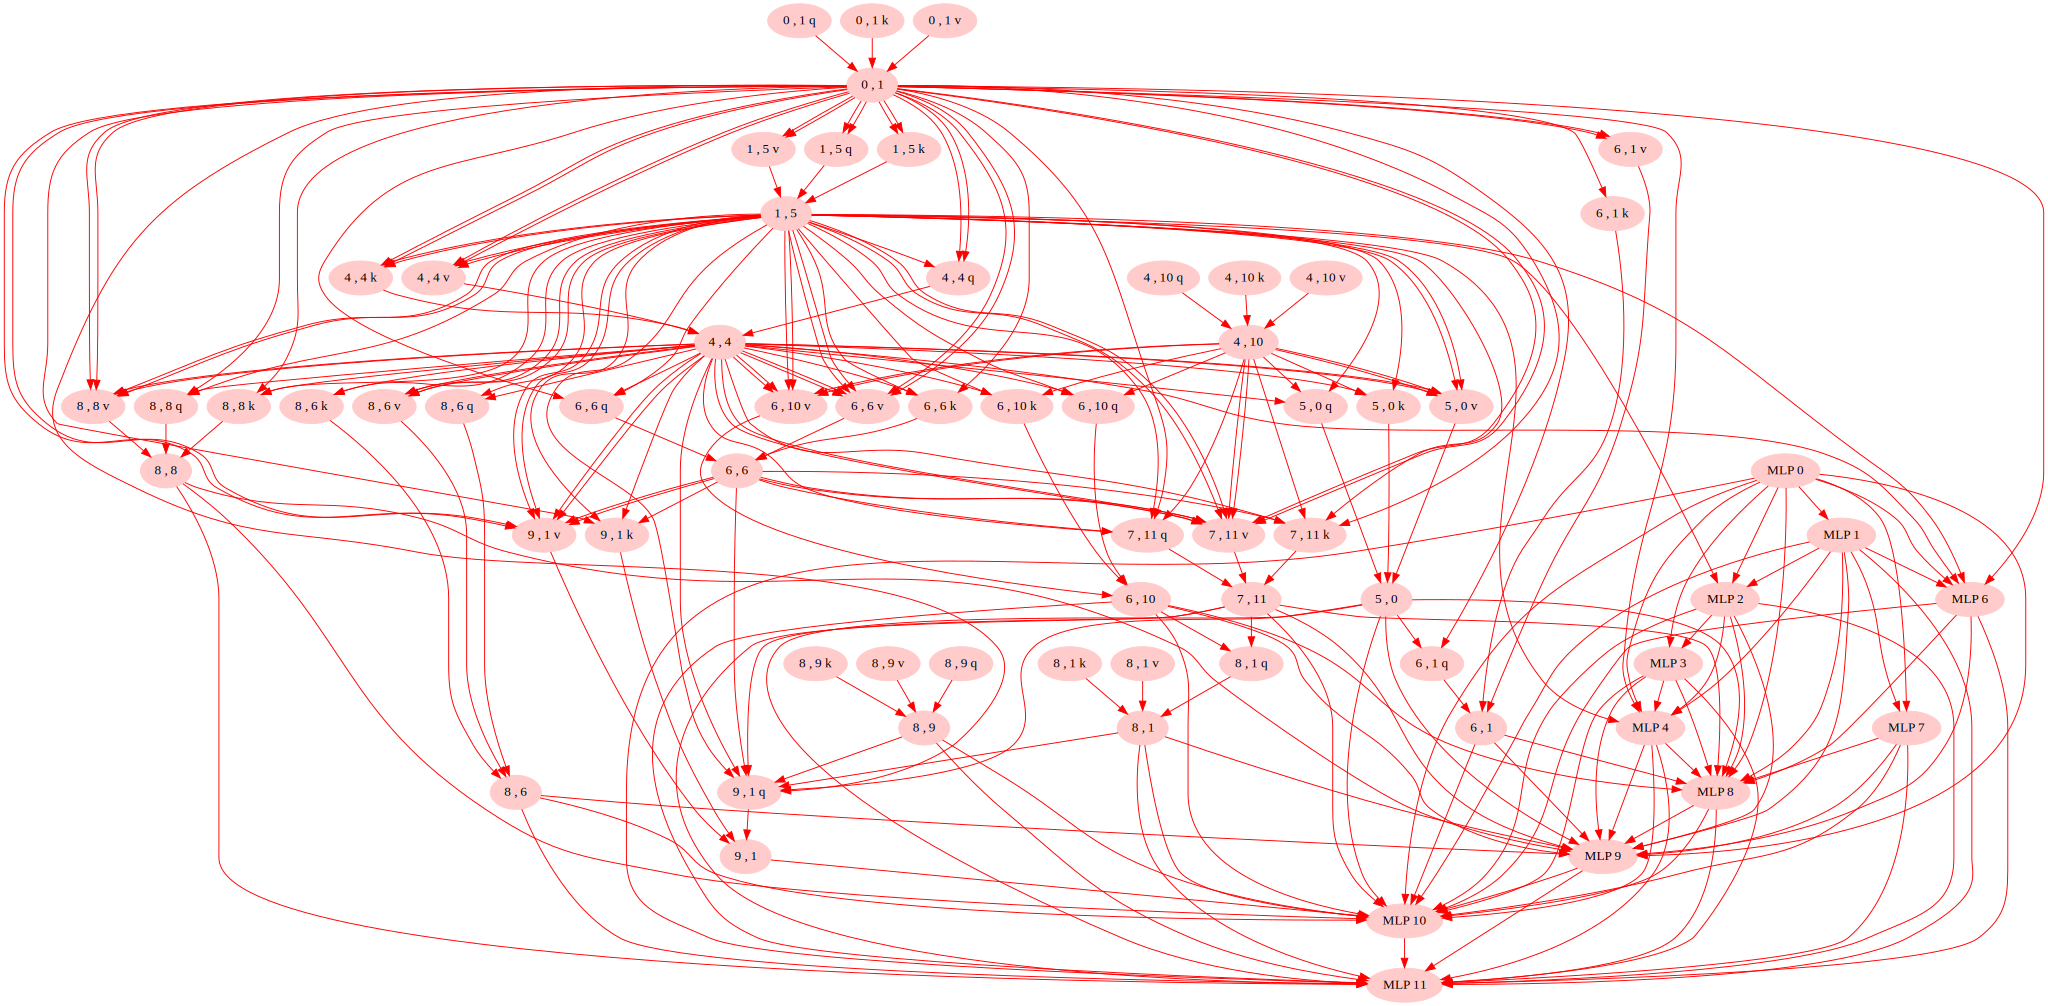

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [115]:
plot_graph_adjacency_qkv(head_to_head_adjList, mlp_to_mlp_adjList, head_to_mlp_adjList, mlp_to_head_adjList, filename="qkv")

# rewrite no qkv fn

In [108]:
def plot_graph_adjacency(head_to_head_adjList, mlp_to_mlp_adjList, head_to_mlp_adjList, filename="circuit_graph", highlighted_nodes=None):
    dot = Digraph()
    dot.attr(ranksep='0.45', nodesep='0.12')  # Adjust the rankdir, ranksep, and nodesep (defaults 0.75, 0.25)

    for node in head_to_head_adjList.keys():
        sender_name = f"{node[0]} , {node[1]}"
        dot.node(sender_name, color="#ffcccb", style='filled')

    for node in mlp_to_mlp_adjList.keys():
        sender_name = "MLP " + str(node)
        dot.node(sender_name, color="#ffcccb", style='filled')

    def loop_adjList(adjList):
        for end_node, start_nodes_list in adjList.items():
            if isinstance(end_node, int):
                receiver_name = "MLP " + str(end_node)
            elif isinstance(end_node, tuple):
                receiver_name = f"{end_node[0]} , {end_node[1]}"
            for start in start_nodes_list:
                if isinstance(start, int):
                    sender_name = "MLP " + str(start)
                elif isinstance(start, tuple):
                    sender_name = f"{start[0]} , {start[1]}"
                dot.edge(sender_name, receiver_name, color = 'red')

    loop_adjList(head_to_head_adjList)
    loop_adjList(mlp_to_mlp_adjList)
    loop_adjList(head_to_mlp_adjList)

    # Display the graph in Colab
    display(Source(dot.source))

    # Save the graph to a file
    dot.format = 'png'  # You can change this to 'pdf', 'png', etc. based on your needs
    dot.render(filename)
    files.download(filename + ".png")

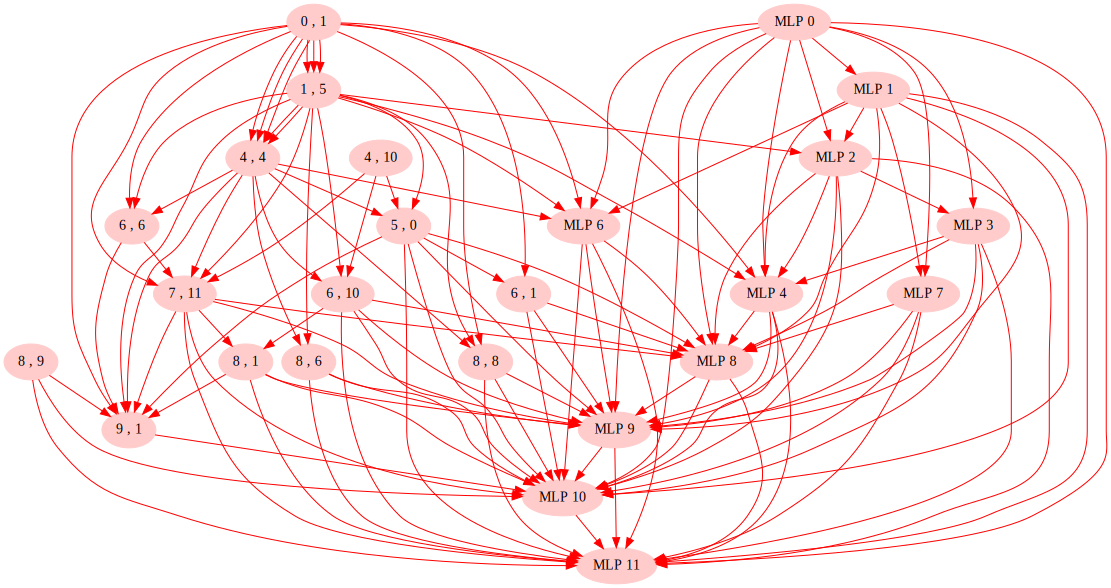

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [109]:
plot_graph_adjacency(head_to_head_adjList, mlp_to_mlp_adjList, head_to_mlp_adjList, filename="no_qkv")

# resid post

## res fn

In [123]:
def get_path_patch_head_to_final_resid_post(
    circuit: List[Tuple[int, int]],
    model: HookedTransformer,
    patching_metric: Callable,
    new_dataset: IOIDataset = dataset_2,
    orig_dataset: IOIDataset = dataset_1,
) -> Float[Tensor, "layer head"]:
    '''
    Performs path patching (see algorithm in appendix B of IOI paper), with:

        sender head = (each head, looped through, one at a time)
        receiver node = final value of residual stream

    Returns:
        tensor of metric values for every possible sender head
    '''
    # model.reset_hooks()
    results = t.zeros(model.cfg.n_layers, model.cfg.n_heads, device="cuda", dtype=t.float32)

    resid_post_hook_name = utils.get_act_name("resid_post", model.cfg.n_layers - 1)
    resid_post_name_filter = lambda name: name == resid_post_hook_name


    # ========== Step 1 ==========
    # Gather activations on x_orig and x_new

    # Note the use of names_filter for the run_with_cache function. Using it means we
    # only cache the things we need (in this case, just attn head outputs).
    z_name_filter = lambda name: name.endswith("z")

    _, new_cache = model.run_with_cache(
        new_dataset.toks,
        names_filter=z_name_filter,
        return_type=None
    )

    _, orig_cache = model.run_with_cache(
        orig_dataset.toks,
        names_filter=z_name_filter,
        return_type=None
    )

    # Looping over every possible sender head (the receiver is always the final resid_post)
    # Note use of itertools (gives us a smoother progress bar)
    # for (sender_layer, sender_head) in tqdm(list(itertools.product(range(model.cfg.n_layers), range(model.cfg.n_heads)))):

    for (sender_layer, sender_head) in tqdm(circuit):

        # ========== Step 2 ==========
        # Run on x_orig, with sender head patched from x_new, every other head frozen

        hook_fn = partial(
            patch_or_freeze_head_vectors,
            new_cache=new_cache,
            orig_cache=orig_cache,
            head_to_patch=(sender_layer, sender_head),
        )
        model.add_hook(z_name_filter, hook_fn)

        _, patched_cache = model.run_with_cache(
            orig_dataset.toks,
            names_filter=resid_post_name_filter,
            return_type=None
        )

        assert set(patched_cache.keys()) == {resid_post_hook_name}

        # ========== Step 3 ==========
        # Unembed the final residual stream value, to get our patched logits

        patched_logits = model.unembed(model.ln_final(patched_cache[resid_post_hook_name]))

        # Save the results
        results[sender_layer, sender_head] = patching_metric(patched_logits)

    return results

## test head to head

In [124]:
model.reset_hooks()
model = add_mean_ablation_hook_MLP_head(model, dataset_2, heads_not_ablate, mlps_not_ablate)

path_patch_head_to_final_resid_post = get_path_patch_head_to_final_resid_post(heads_not_ablate, model, ioi_metric_3)

  0%|          | 0/14 [00:00<?, ?it/s]

In [119]:
path_patch_head_to_final_resid_post.size()

torch.Size([12, 12])

In [130]:
heads_to_resid = {}
result = path_patch_head_to_final_resid_post
filtered_indices = (result < 0.8) & (result != 0.0)
rows, cols = filtered_indices.nonzero(as_tuple=True)
heads_to_resid['resid'] = list(zip(rows.tolist(), cols.tolist()))

In [131]:
heads_to_resid

{'resid': [(5, 0),
  (6, 1),
  (6, 10),
  (7, 11),
  (8, 1),
  (8, 6),
  (8, 8),
  (8, 9),
  (9, 1)]}

## mlp to resid

In [ ]:
def circ_path_patch_mlp_to_head(
    mlp_circuit: List[int],
    receiver_heads: List[Tuple[int, int]],
    # receiver_layers: List[int],
    receiver_input: str,
    model: HookedTransformer,
    patching_metric: Callable,
    new_dataset: IOIDataset = dataset_2,
    orig_dataset: IOIDataset = dataset_1,
    new_cache: Optional[ActivationCache] = None,
    orig_cache: Optional[ActivationCache] = None,
) -> Float[Tensor, "layer head"]:
    '''
    Performs path patching (see algorithm in appendix B of IOI paper), with:

        sender head = (each head, looped through, one at a time)
        receiver node = input to a later head (or set of heads)

    The receiver node is specified by receiver_heads and receiver_input.
    Example (for S-inhibition path patching the queries):
        receiver_heads = [(8, 6), (8, 10), (7, 9), (7, 3)],
        receiver_input = "v"

    Returns:
        tensor of metric values for every possible sender head
    '''
    # model.reset_hooks() # doesn't make diff if comment out or not

    assert receiver_input in ("k", "q", "v", "z")  # we can run get_path_patch_head_to_heads() 3 times for k, q, v!
    receiver_layers = set(next(zip(*receiver_heads)))
    receiver_hook_names = [utils.get_act_name(receiver_input, layer) for layer in receiver_layers]
    # receiver_hook_names = [utils.get_act_name('mlp_out', layer) for layer in receiver_layers]  # modify for mlp_out
    receiver_hook_names_filter = lambda name: name in receiver_hook_names

    # results = t.zeros(max(receiver_layers), model.cfg.n_heads, device="cuda", dtype=t.float32)
    results = t.zeros(max(receiver_layers), device="cuda", dtype=t.float32)

    # ========== Step 1 ==========
    # z_name_filter = lambda name: name.endswith("z")  # this is for sender? actually no; orig cache uses it too
    # z_name_filter = lambda name: name.endswith("mlp_out")
    z_name_filter = lambda name: name.endswith(("z", "mlpout"))  # gets same value as just mlp out

    if new_cache is None:
        _, new_cache = model.run_with_cache(
            new_dataset.toks,
            names_filter=z_name_filter,
            return_type=None
        )
    if orig_cache is None:
        _, orig_cache = model.run_with_cache(
            orig_dataset.toks,
            names_filter=z_name_filter,
            return_type=None
        )

    # Note, the sender layer will always be before the final receiver layer, otherwise there will
    # be no causal effect from sender -> receiver. So we only need to loop this far.

    # for (sender_layer, sender_head) in tqdm(list(itertools.product(
    #     range(max(receiver_layers)),  # all the layers from 0 to highest receiver layer (in circuit)
    #     range(model.cfg.n_heads)  # all heads from 0 to 12
    # ))):

    # have a separate loop for both MLPs AND heads as senders
    # for (sender_layer) in range(max(receiver_layers)):  # all the layers from 0 to highest receiver layer (in circuit)
    sender_mlp_list = [L for L in mlp_circuit if L < receiver_heads[0][0]]
    for (sender_layer) in sender_mlp_list:

        # ========== Step 2 ==========
        # Run on x_orig, with sender head patched from x_new, every other head frozen

        hook_fn = partial(
            # patch_or_freeze_head_vectors,
            patch_or_freeze_mlp_vectors,
            new_cache=new_cache,
            orig_cache=orig_cache,
            # head_to_patch=(sender_layer, sender_head),
            layer_to_patch = sender_layer # an int
        )

        model.add_hook(z_name_filter, hook_fn, level=1)

        _, patched_cache = model.run_with_cache(
            orig_dataset.toks,
            names_filter=receiver_hook_names_filter,
            return_type=None
        )
        # model.reset_hooks(including_permanent=True)
        assert set(patched_cache.keys()) == set(receiver_hook_names)

        # ========== Step 3 ==========
        # Run on x_orig, patching in the receiver node(s) from the previously cached value

        hook_fn = partial(
            patch_head_input,
            # patch_mlp_input,
            patched_cache=patched_cache,
            head_list=receiver_heads, # list of layer ints
            # layer_list=receiver_layers,
        )
        patched_logits = model.run_with_hooks(
            orig_dataset.toks,
            fwd_hooks = [(receiver_hook_names_filter, hook_fn)],
            return_type="logits"
        )

        # Save the results
        # results[sender_layer, sender_head] = patching_metric(patched_logits)
        results[sender_layer] = patching_metric(patched_logits)

    # the result is which sender layers affect ALL the inputted nodes. this is why we just
    # want to pass one node at a time- to see which layers affect just IT.
    # if we want a 'group of nodes under a common type', we'd pass a set of nodes
    return results

In [145]:
def get_path_patch_mlp_to_final_resid_post(
    mlp_circuit: List[int],
    model: HookedTransformer,
    patching_metric: Callable,
    new_dataset: IOIDataset = dataset_2,
    orig_dataset: IOIDataset = dataset_1,
) -> Float[Tensor, "layer head"]:
    '''
    Performs path patching (see algorithm in appendix B of IOI paper), with:

        sender head = (each head, looped through, one at a time)
        receiver node = final value of residual stream

    Returns:
        tensor of metric values for every possible sender head
    '''
    # model.reset_hooks()
    results = t.zeros(model.cfg.n_layers, device="cuda", dtype=t.float32) #model.cfg.n_heads,

    resid_post_hook_name = utils.get_act_name("resid_post", model.cfg.n_layers - 1)
    resid_post_name_filter = lambda name: name == resid_post_hook_name


    # ========== Step 1 ==========
    # Gather activations on x_orig and x_new

    # Note the use of names_filter for the run_with_cache function. Using it means we
    # only cache the things we need (in this case, just attn head outputs).
    z_name_filter = lambda name: name.endswith(("z", "mlp_out"))

    _, new_cache = model.run_with_cache(
        new_dataset.toks,
        names_filter=z_name_filter,
        return_type=None
    )

    _, orig_cache = model.run_with_cache(
        orig_dataset.toks,
        names_filter=z_name_filter,
        return_type=None
    )

    # Looping over every possible sender head (the receiver is always the final resid_post)
    # Note use of itertools (gives us a smoother progress bar)
    # for (sender_layer, sender_head) in tqdm(list(itertools.product(range(model.cfg.n_layers), range(model.cfg.n_heads)))):

    # for (sender_layer, sender_head) in tqdm(circuit):
    for sender_layer in mlp_circuit:

        # ========== Step 2 ==========
        # Run on x_orig, with sender head patched from x_new, every other head frozen

        hook_fn = partial(
            # patch_or_freeze_head_vectors,
            patch_or_freeze_mlp_vectors,
            new_cache=new_cache,
            orig_cache=orig_cache,
            # head_to_patch=(sender_layer, sender_head),
            layer_to_patch = sender_layer # an int
        )
        model.add_hook(z_name_filter, hook_fn)

        _, patched_cache = model.run_with_cache(
            orig_dataset.toks,
            names_filter=resid_post_name_filter,
            return_type=None
        )

        assert set(patched_cache.keys()) == {resid_post_hook_name}

        # ========== Step 3 ==========
        # Unembed the final residual stream value, to get our patched logits

        patched_logits = model.unembed(model.ln_final(patched_cache[resid_post_hook_name]))

        # Save the results
        # results[sender_layer, sender_head] = patching_metric(patched_logits)
        results[sender_layer] = patching_metric(patched_logits)

    return results

In [146]:
model.reset_hooks()
model = add_mean_ablation_hook_MLP_head(model, dataset_2, heads_not_ablate, mlps_not_ablate)

path_patch_mlp_to_final_resid_post = get_path_patch_mlp_to_final_resid_post(mlps_not_ablate, model, ioi_metric_3)

In [148]:
path_patch_mlp_to_final_resid_post.size()

torch.Size([12])

In [ ]:
mlp_to_mlp_adjList = {}
for mlp in mlps_not_ablate:
    result = mlp_to_mlp_results[mlp]
    filtered_indices = (result < 0.80) & (result != 0.0)
    filtered_indices = filtered_indices.nonzero(as_tuple=True)[0]
    mlp_to_mlp_adjList[mlp] = filtered_indices.tolist()
mlp_to_mlp_adjList

In [153]:
mlps_to_resid = {}
result = path_patch_mlp_to_final_resid_post
filtered_indices = (result < 0.8) & (result != 0.0)
filtered_indices = filtered_indices.nonzero(as_tuple=True)[0]
mlps_to_resid['resid'] = filtered_indices.tolist()

In [155]:
mlps_to_resid

{'resid': [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11]}

## filter out nodes with no ingoing edges

In [158]:
head_to_head_adjList

{(0, 1, 'q'): [],
 (1, 5, 'q'): [(0, 1)],
 (4, 4, 'q'): [(0, 1)],
 (4, 10, 'q'): [],
 (5, 0, 'q'): [],
 (6, 1, 'q'): [(5, 0)],
 (6, 6, 'q'): [],
 (6, 10, 'q'): [],
 (7, 11, 'q'): [],
 (8, 1, 'q'): [(6, 10), (7, 11)],
 (8, 6, 'q'): [],
 (8, 8, 'q'): [],
 (8, 9, 'q'): [],
 (9, 1, 'q'): [(5, 0), (7, 11), (8, 1), (8, 9)],
 (0, 1, 'k'): [],
 (1, 5, 'k'): [(0, 1)],
 (4, 4, 'k'): [(0, 1), (1, 5)],
 (4, 10, 'k'): [],
 (5, 0, 'k'): [],
 (6, 1, 'k'): [],
 (6, 6, 'k'): [],
 (6, 10, 'k'): [],
 (7, 11, 'k'): [],
 (8, 1, 'k'): [],
 (8, 6, 'k'): [],
 (8, 8, 'k'): [],
 (8, 9, 'k'): [],
 (9, 1, 'k'): [],
 (0, 1, 'v'): [],
 (1, 5, 'v'): [(0, 1)],
 (4, 4, 'v'): [(0, 1), (1, 5)],
 (4, 10, 'v'): [],
 (5, 0, 'v'): [(1, 5), (4, 4), (4, 10)],
 (6, 1, 'v'): [(0, 1)],
 (6, 6, 'v'): [(0, 1), (1, 5), (4, 4)],
 (6, 10, 'v'): [(1, 5), (4, 4), (4, 10)],
 (7, 11, 'v'): [(0, 1), (1, 5), (4, 4), (4, 10), (6, 6)],
 (8, 1, 'v'): [],
 (8, 6, 'v'): [(1, 5), (4, 4)],
 (8, 8, 'v'): [(0, 1), (1, 5), (4, 4)],
 (8, 9, 'v'): [],

In [161]:
head_to_head_adjList = {node: neighbors for node, neighbors in head_to_head_adjList.items() if neighbors}

In [176]:
mlp_to_head_adjList = {node: neighbors for node, neighbors in mlp_to_head_adjList.items() if neighbors}

## graph with resid

### plot qkv

In [185]:
from graphviz import Digraph, Source
from IPython.display import display
from google.colab import files

def plot_graph_adjacency_qkv(head_to_head_adjList, mlp_to_mlp_adjList, head_to_mlp_adjList,
                             mlp_to_head_adjList, heads_to_resid, mlps_to_resid,
                             filename="circuit_graph", highlighted_nodes=None):
    dot = Digraph()
    dot.attr(ranksep='0.45', nodesep='0.12')  # Adjust the rankdir, ranksep, and nodesep (defaults 0.75, 0.25)

    dot.node('resid_post', color="#ffcccb", style='filled')

    for node in mlp_to_mlp_adjList.keys():
        sender_name = "MLP " + str(node)
        dot.node(sender_name, color="#ffcccb", style='filled')

    for node in head_to_head_adjList.keys():
        sender_name = f"{node[0]} , {node[1]} {node[2]}"
        dot.node(sender_name, color="#ffcccb", style='filled')
        sender_name = f"{node[0]} , {node[1]}"
        dot.node(sender_name, color="#ffcccb", style='filled')

    # for every q k v node, plot an edge to output node
    for node in head_to_head_adjList.keys():
        sender_name = f"{node[0]} , {node[1]} {node[2]}"
        receiver_name = f"{node[0]} , {node[1]}"
        dot.edge(sender_name, receiver_name, color = 'red')

    for node in mlp_to_head_adjList.keys():
        sender_name = f"{node[0]} , {node[1]} {node[2]}"
        dot.node(sender_name, color="#ffcccb", style='filled')
        sender_name = f"{node[0]} , {node[1]}"
        dot.node(sender_name, color="#ffcccb", style='filled')

    # for every q k v node, plot an edge to output node
    for node in mlp_to_head_adjList.keys():
        sender_name = f"{node[0]} , {node[1]} {node[2]}"
        receiver_name = f"{node[0]} , {node[1]}"
        dot.edge(sender_name, receiver_name, color = 'red')

    def loop_adjList(adjList):
        for end_node, start_nodes_list in adjList.items():
            if isinstance(end_node, int):
                receiver_name = "MLP " + str(end_node)
            elif isinstance(end_node, tuple):
                if len(end_node) == 3:
                    receiver_name = f"{end_node[0]} , {end_node[1]} {end_node[2]}"
                elif len(end_node) == 2:
                    receiver_name = f"{end_node[0]} , {end_node[1]}"
            else:
                receiver_name = 'resid_post'
            for start in start_nodes_list:
                if isinstance(start, int):
                    sender_name = "MLP " + str(start)
                elif isinstance(start, tuple):
                    if len(start) == 3:
                        sender_name = f"{start[0]} , {start[1]} {start[2]}"
                    elif len(start) == 2:
                        sender_name = f"{start[0]} , {start[1]}"
                dot.node(sender_name, color="#ffcccb", style='filled')
                dot.node(receiver_name, color="#ffcccb", style='filled')
                dot.edge(sender_name, receiver_name, color = 'red')

    loop_adjList(head_to_head_adjList)
    loop_adjList(mlp_to_mlp_adjList)
    loop_adjList(head_to_mlp_adjList)
    loop_adjList(mlp_to_head_adjList)
    loop_adjList(heads_to_resid)
    loop_adjList(mlps_to_resid)

    # Display the graph in Colab
    # display(Source(dot.source))

    # Save the graph to a file
    dot.format = 'png'  # You can change this to 'pdf', 'png', etc. based on your needs
    dot.render(filename)
    files.download(filename + ".png")

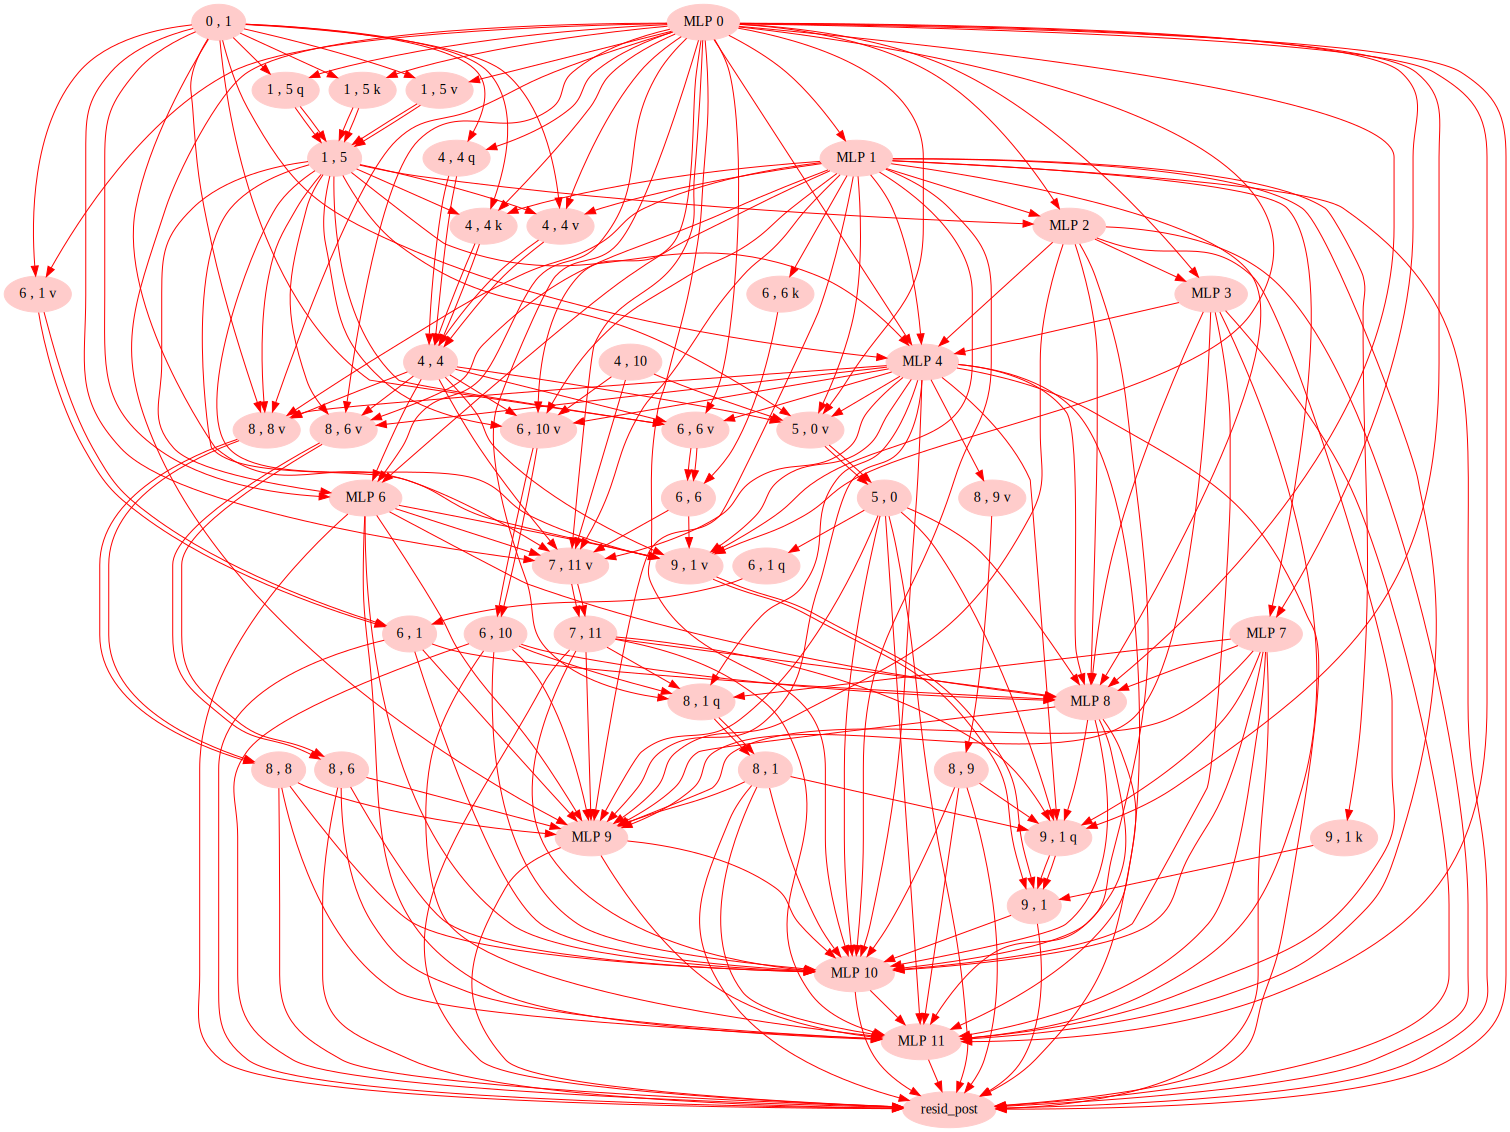

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [186]:
plot_graph_adjacency_qkv(head_to_head_adjList, mlp_to_mlp_adjList, head_to_mlp_adjList,
                         mlp_to_head_adjList, heads_to_resid, mlps_to_resid, filename="qkv")

### rewrite no qkv fn

In [190]:
def plot_graph_adjacency(head_to_head_adjList, mlp_to_mlp_adjList, head_to_mlp_adjList,
                             mlp_to_head_adjList, heads_to_resid, mlps_to_resid,
                             filename="circuit_graph", highlighted_nodes=None):
    dot = Digraph()
    dot.attr(ranksep='0.45', nodesep='0.12')  # Adjust the rankdir, ranksep, and nodesep (defaults 0.75, 0.25)

    def loop_adjList(adjList):
        for end_node, start_nodes_list in adjList.items():
            if isinstance(end_node, int):
                receiver_name = "MLP " + str(end_node)
            elif isinstance(end_node, tuple):
                receiver_name = f"{end_node[0]} , {end_node[1]}"
            else:
                receiver_name = 'resid_post'
            for start in start_nodes_list:
                if isinstance(start, int):
                    sender_name = "MLP " + str(start)
                elif isinstance(start, tuple):
                    sender_name = f"{start[0]} , {start[1]}"
                dot.node(sender_name, color="#ffcccb", style='filled')
                dot.node(receiver_name, color="#ffcccb", style='filled')
                dot.edge(sender_name, receiver_name, color = 'red')

    loop_adjList(head_to_head_adjList)
    loop_adjList(mlp_to_mlp_adjList)
    loop_adjList(head_to_mlp_adjList)
    loop_adjList(mlp_to_head_adjList)
    loop_adjList(heads_to_resid)
    loop_adjList(mlps_to_resid)

    # Save the graph to a file
    dot.format = 'png'  # You can change this to 'pdf', 'png', etc. based on your needs
    dot.render(filename)
    files.download(filename + ".png")

In [191]:
plot_graph_adjacency(head_to_head_adjList, mlp_to_mlp_adjList, head_to_mlp_adjList,
                         mlp_to_head_adjList, heads_to_resid, mlps_to_resid, filename="no qkv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Path patching expms

## iter patch from 97% bf moredata incorr i+3

https://colab.research.google.com/drive/1A3EgZW_0HWrIX3woMk8ZEdrbEQid25Yq#scrollTo=zI9JKq-frrx3&line=3&uniqifier=1

In [ ]:
circuit = [(0, 1), (0, 2), (0, 5), (0, 7), (0, 8), (0, 10), (1, 0), (1, 1), (1, 3), (1, 5), (1, 7), (1, 11), (2, 0), (2, 1), (2, 2), (2, 3), (2, 5), (2, 6), (2, 8), (2, 9), (2, 10), (3, 3), (3, 7), (3, 8), (3, 10), (3, 11), (4, 2), (4, 4), (4, 6), (4, 10), (4, 11), (5, 1), (5, 4), (5, 8), (5, 10), (5, 11), (6, 2), (6, 3), (6, 4), (6, 6), (6, 7), (6, 8), (6, 9), (6, 10), (6, 11), (7, 11), (8, 6), (8, 8), (9, 1), (10, 7), (11, 10)]
topperc = 3

In [ ]:
%%capture
results_dict = {}
for head in circuit:
    model.reset_hooks()
    result = get_path_patch_head_to_heads(
        receiver_heads = [head],
        receiver_input = "v",
        model = model,
        patching_metric = ioi_metric_2
    )
    results_dict[head] = result

In [ ]:
def thres_at_perc(results_dict, perc):
    # the top perc%
    all_values = []
    for result_tensor in results_dict.values():
        all_values.extend(result_tensor.cpu().numpy().flatten())
    sorted_values = sorted(all_values)

    ind_perc = (100 - perc)/100

    # Calculate the index for the top %
    index_percent = int(ind_perc * len(sorted_values))

    # Retrieve the value at that index
    value_at_percent = sorted_values[index_percent]
    return value_at_percent

In [ ]:
%%capture
Ethres = thres_at_perc(results_dict, topperc)

head_adjList = {}
for head in circuit:
    result = results_dict[head]
    head_adjList[head] = edges_within_threshold(result, Ethres)

In [ ]:
# only keep nodes that were part of original circuit
all_keys = set(head_adjList.keys())
# Iterate through the dictionary and filter the list values
for key, value in head_adjList.items():
    head_adjList[key] = [item for item in value if item in all_keys]

In [ ]:
# Filter out nodes that don't have outgoing edges except for (9,1) and (10, 7)
# head_adjList = {node: neighbors for node, neighbors in head_adjList.items() if neighbors or node == (9,1) or node == (10,7)}

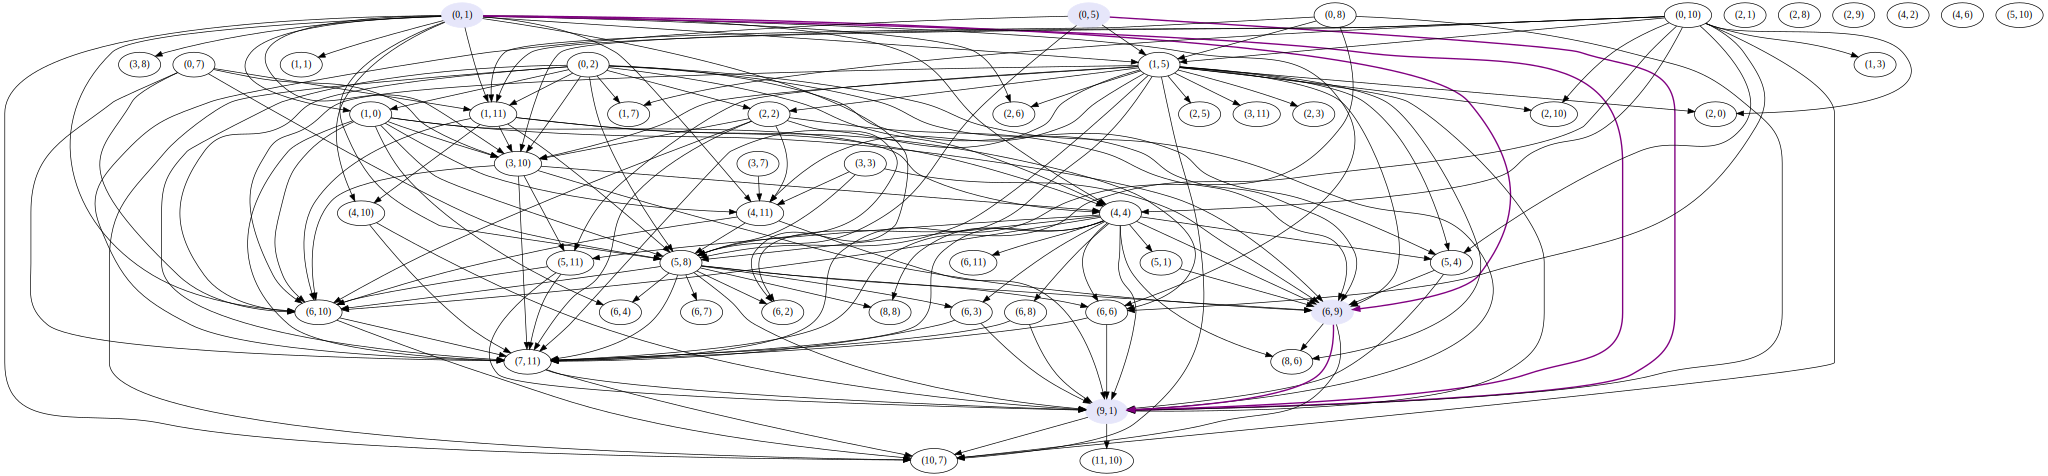

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
plot_graph_adjacency(head_adjList, filename="circuit_graph_top"+str(topperc)+"_perc", highlighted_nodes=greater_than)

In [ ]:
import pickle

with open("results_dict.pkl", "wb") as file:
    pickle.dump(results_dict, file)
files.download("results_dict.pkl")

with open("head_adjList.pkl", "wb") as file:
    pickle.dump(head_adjList, file)
files.download("head_adjList.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## iter patch from 80% bf moredata incorr i+3

https://colab.research.google.com/drive/1WsZXGXtWLHdvkP93Qd4jenE1kzKySz9o#scrollTo=04ILHSBb0qT4&line=4&uniqifier=1

In [ ]:
circuit = [(0, 1), (0, 2), (0, 5), (0, 7), (0, 8), (0, 10), (1, 0), (1, 1), (1, 5), (1, 7), (1, 11), (2, 0), (2, 1), (2, 2), (2, 3), (2, 6), (2, 8), (2, 9), (2, 10), (2, 11), (3, 3), (3, 4), (3, 5), (3, 7), (3, 8), (3, 9), (3, 11), (4, 4), (4, 10), (5, 1), (5, 4), (5, 6), (5, 8), (5, 11), (6, 4), (6, 6), (6, 7), (6, 8), (6, 9), (6, 10), (6, 11), (7, 11), (9, 1)]
topperc = 5

In [ ]:
%%capture
results_dict = {}
for head in circuit:
    model.reset_hooks()
    result = get_path_patch_head_to_heads(
        receiver_heads = [head],
        receiver_input = "v",
        model = model,
        patching_metric = ioi_metric_2
    )
    results_dict[head] = result

In [ ]:
def thres_at_perc(results_dict, perc):
    # the top perc%
    all_values = []
    for result_tensor in results_dict.values():
        all_values.extend(result_tensor.cpu().numpy().flatten())
    sorted_values = sorted(all_values)

    ind_perc = (100 - perc)/100

    # Calculate the index for the top %
    index_percent = int(ind_perc * len(sorted_values))

    # Retrieve the value at that index
    value_at_percent = sorted_values[index_percent]
    return value_at_percent

In [ ]:
%%capture
Ethres = thres_at_perc(results_dict, topperc)

head_adjList = {}
for head in circuit:
    result = results_dict[head]
    head_adjList[head] = edges_within_threshold(result, Ethres)

In [ ]:
# only keep nodes that were part of original circuit
all_keys = set(head_adjList.keys())
# Iterate through the dictionary and filter the list values
for key, value in head_adjList.items():
    head_adjList[key] = [item for item in value if item in all_keys]

In [ ]:
# Filter out nodes that don't have outgoing edges except for (9,1) and (10, 7)
# head_adjList = {node: neighbors for node, neighbors in head_adjList.items() if neighbors or node == (9,1) or node == (10,7)}

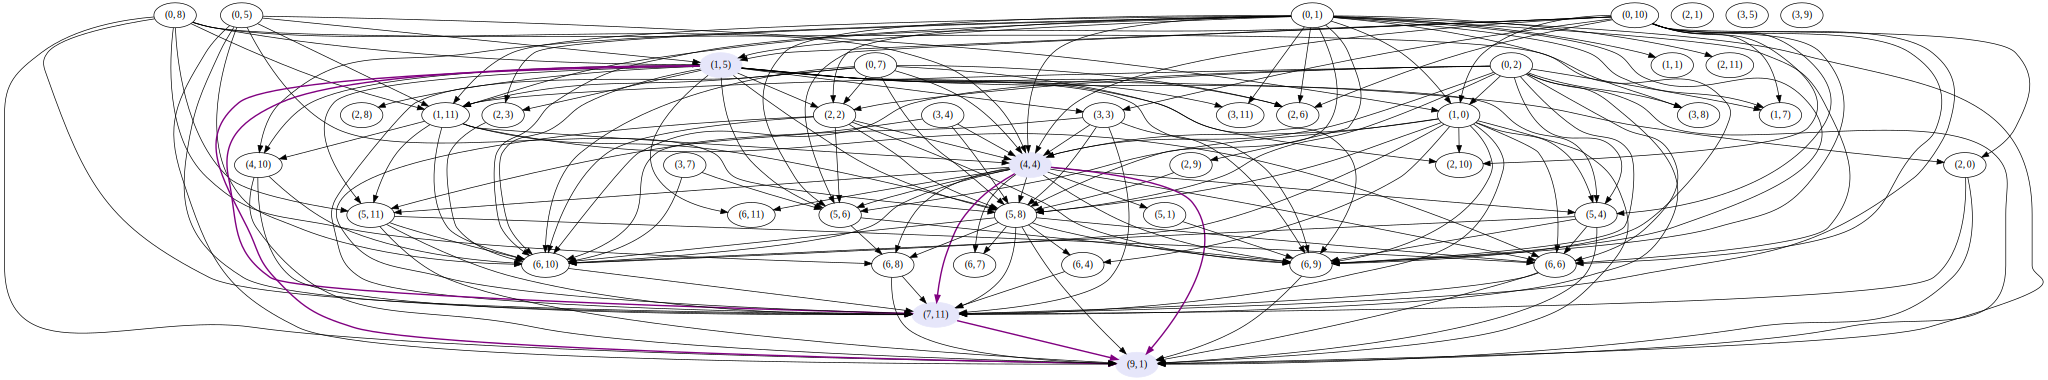

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
plot_graph_adjacency(head_adjList, filename="circuit_graph_top"+str(topperc)+"_perc", highlighted_nodes=[(1,5), (4,4), (7,11), (9,1)])

In [ ]:
import pickle

with open("results_dict.pkl", "wb") as file:
    pickle.dump(results_dict, file)
files.download("results_dict.pkl")

with open("head_adjList.pkl", "wb") as file:
    pickle.dump(head_adjList, file)
files.download("head_adjList.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>